<a id='home'></a>
### purpose

figures showing effect of nuisance envs on within-landscape performance

### outline

1. [load data](#data)
1. [create figures](#figs)
    1. [nuisance by program](#nbp)
    1. [program by nuisance](#pbn)
    1. [landscape by nuisance](#lbn)
    1. [landscape by program by nuisance](#lbpbn)
    1. [marker set by program by nuisance](#msbpbn)
    1. [nuisance by program by marker set](#nbpbms)

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf, scatter2d, draw_xy, histo_box

import MVP_summary_functions as mvp

import itertools as it
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene  # brown-forsythe test of equal variance
plt.rcParams.update({'font.family' : 'serif'})

t0 = dt.now()  # notebook timer

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs'
figdir = makedir(op.join(summarydir, 'figs'))

mvp.latest_commit()
session_info.show()

#########################################################
Today:	November 01, 2023 - 11:28:46 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 782ee79eada654ce337935bf61a0984cd76dd9cf  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Oct 4 14:13:12 2023 -0400
#########################################################



<a id='data'></a>
# 1. load data

[top](#home)

In [2]:
# get all_scores data
one_rep_scores = mvp.combine_program_data(
    mvp.combine_level_dicts(
        use_bcs_data=False,
        keep_nuisance=True,
        repdirs = ['/work/lotterhos/MVP-Offsets/run_20220919_0-225']
    )
)

# remove RONA
one_rep_scores = one_rep_scores[~one_rep_scores.program.str.contains('RONA')].reset_index(drop=True)

# annotate
one_rep_scores['nuis_envs'] = one_rep_scores.noncausal_env.map(mvp.factor_names)

one_rep_scores

filtering criteria:
	use_bcs_data = False
	performance = garden_performance
	num_traits = None
	ntraits = None
	marker_set = None
	remove_structcrxn = False
	keep_nuisance = True
	remove_rda_outliers = True


reading reps: 100%|███████████████| 1/1 [00:01<00:00,  1.77s/it]


0-225
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225



 RONA df.shape = (135000, 16) num_seeds = 225 num_reps = 1

 lfmm2 df.shape = (81000, 17) num_seeds = 225 num_reps = 1

 GF df.shape = (81000, 16) num_seeds = 225 num_reps = 1

 rda df.shape = (162000, 18) num_seeds = 225 num_reps = 1
Function `combine_level_dicts` completed after : 0-00:00:03


garden     score            glevel   plevel          pleio     slevel  \
0            1 -0.679192  highly-polygenic  1-trait  no pleiotropy        NaN   
1            2 -0.673131  highly-polygenic  1-trait  no pleiotropy        NaN   
2            3 -0.675556  highly-polygenic  1-trait  no pleiotropy        NaN   
3            4 -0.669495  highly-polygenic  1-trait  no pleiotropy        NaN   
4            5 -0.677980  highly-polygenic  1-trait  no pleiotropy        NaN   
...        ...       ...               ...      ...            ...        ...   
323995      96 -0.826693        oligogenic  2-trait     pleiotropy  unequal-S   
323996      97 -0.726674        oligogenic  2-trait     pleiotropy  unequal-S   
323997      98 -0.678194        oligogenic  2-trait     pleiotropy  unequal-S   
323998      99 -0.817686        oligogenic  2-trait     pleiotropy  unequal-S   
323999     100 -0.862433        oligogenic  2-trait     pleiotropy  unequal-S   

         landscape                 popsize   migration marker_set     seed  \
0       Est-Clines  N-cline-center-to-edge  m-constant        all  1231094   
1       Est-Clines  N-cline-center-to-edge  m-constant        all  1231094   
2       Est-Clines  N-cline-center-to-edge  m-constant        all  1231094   
3       Est-Clines  N-cline-center-to-edge  m-constant        all  1231094   
4       Est-Clines  N-cline-center-to-edge  m-constant        all  1231094   
...            ...                     ...         ...        ...      ...   
323995      SS-Mtn              N-variable  m-variable    neutral  1231318   
323996      SS-Mtn              N-variable  m-variable    neutral  1231318   
323997      SS-Mtn              N-variable  m-variable    neutral  1231318   
323998      SS-Mtn              N-variable  m-variable    neutral  1231318   
323999      SS-Mtn              N-variable  m-variable    neutral  1231318   

                                         simulation_level  env  \
0       highly-polygenic_1-trait_no-pleiotropy_nan_Est...  NaN   
1       highly-polygenic_1-trait_no-pleiotropy_nan_Est...  NaN   
2       highly-polygenic_1-trait_no-pleiotropy_nan_Est...  NaN   
3       highly-polygenic_1-trait_no-pleiotropy_nan_Est...  NaN   
4       highly-polygenic_1-trait_no-pleiotropy_nan_Est...  NaN   
...                                                   ...  ...   
323995  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  NaN   
323996  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  NaN   
323997  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  NaN   
323998  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  NaN   
323999  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  NaN   

                                             offset_level         program  \
0       highly-polygenic_1-trait_no-pleiotropy_nan_Est...           lfmm2   
1       highly-polygenic_1-trait_no-pleiotropy_nan_Est...           lfmm2   
2       highly-polygenic_1-trait_no-pleiotropy_nan_Est...           lfmm2   
3       highly-polygenic_1-trait_no-pleiotropy_nan_Est...           lfmm2   
4       highly-polygenic_1-trait_no-pleiotropy_nan_Est...           lfmm2   
...                                                   ...             ...   
323995  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
323996  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
323997  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
323998  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
323999  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   

          rep                                  simulation_garden  final_LA  \
0       0-225  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0.500854   
1       0-225  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0.500854   
2       0-225  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0.500854   
3       0-225  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0.

In [3]:
one_rep_scores.nuis_envs.value_counts()

2-trait 0-nuisance    216000
1-trait 0-nuisance     54000
1-trait 1-nuisance     54000
Name: nuis_envs, dtype: int64

In [4]:
one_rep_scores.program.value_counts()

lfmm2             81000
GF                81000
rda-nocorr        81000
rda-structcorr    81000
Name: program, dtype: int64

###  get other nuisance data from 2-trait sims with nuisance data

In [5]:
outerdirs = {
    'ISO-PSsd' : '/home/b.lind/offsets/run_20220919_nuisance/ISO-PSsd_0-225',
    'ISO-TSsd-PSsd' : '/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_0-225'
}

# convert scores to dataframe, add some labels
summary = mvp.get_summary_data()  # read in all simulation metadata

scores = []
for nuis_envs, outerdir in outerdirs.items():
    # load the scores
    level_scores = pklload(f'{outerdir}/summaries/all_performance_dicts/level_scores.pkl')

    # get the good info
    for program in level_scores.keys():
        df = level_scores[program]['garden_performance']

        # do some things that mvp.combine_level_dicts does
        df['rep'] = '0-225'  # add rep ID - this was only reps that were done
        for col in ['final_LA', 'cor_TPR_temp', 'cor_TPR_sal', 'cor_FPR_temp_neutSNPs', 'cor_FPR_sal_neutSNPs']:  # get other info
            df[col] = df.seed.map(summary[col])

        # name the nuis envs
        df['nuis_envs'] = nuis_envs

        # prepend sal to 1-trait sims
        df.loc[df.plevel == '1-trait', 'nuis_envs'] = 'sal-' + df.loc[df.plevel == '1-trait', 'nuis_envs']
        
        if program == 'rda':
            df['program'] = 'rda' + '-' + df['structcrxn']
            df = df[~df.marker_set.str.contains('outlier')]  # remove RDA outliers
        else:
            df['program'] = program

        scores.append(df)
    
nuis_scores = pd.concat(scores)

# nuis_scores['nuis_envs'] = nuis_scores['nuis_envs'].map(mvp.nuis_dict)
nuis_scores['nuis_envs'] = nuis_scores['nuis_envs'].map(mvp.factor_names)

nuis_scores

garden     score            glevel   plevel          pleio  \
1231094       1 -0.631111  highly-polygenic  1-trait  no pleiotropy   
1231094       2 -0.644040  highly-polygenic  1-trait  no pleiotropy   
1231094       3 -0.648485  highly-polygenic  1-trait  no pleiotropy   
1231094       4 -0.635556  highly-polygenic  1-trait  no pleiotropy   
1231094       5 -0.637172  highly-polygenic  1-trait  no pleiotropy   
...         ...       ...               ...      ...            ...   
1231318      96 -0.542479        oligogenic  2-trait     pleiotropy   
1231318      97  0.281847        oligogenic  2-trait     pleiotropy   
1231318      98 -0.193353        oligogenic  2-trait     pleiotropy   
1231318      99 -0.669765        oligogenic  2-trait     pleiotropy   
1231318     100 -0.668552        oligogenic  2-trait     pleiotropy   

            slevel   landscape                 popsize   migration marker_set  \
1231094        NaN  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231094        NaN  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231094        NaN  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231094        NaN  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231094        NaN  Est-Clines  N-cline-center-to-edge  m-constant        all   
...            ...         ...                     ...         ...        ...   
1231318  unequal-S      SS-Mtn              N-variable  m-variable    neutral   
1231318  unequal-S      SS-Mtn              N-variable  m-variable    neutral   
1231318  unequal-S      SS-Mtn              N-variable  m-variable    neutral   
1231318  unequal-S      SS-Mtn              N-variable  m-variable    neutral   
1231318  unequal-S      SS-Mtn              N-variable  m-variable    neutral   

            seed                                   simulation_level  \
1231094  1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...   
1231094  1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...   
1231094  1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...   
1231094  1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...   
1231094  1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...   
...          ...                                                ...   
1231318  1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...   
1231318  1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...   
1231318  1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...   
1231318  1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...   
1231318  1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...   

           ntraits noncausal_env  \
1231094  ntraits-4  no noncausal   
1231094  ntraits-4  no noncausal   
1231094  ntraits-4  no noncausal   
1231094  ntraits-4  no noncausal   
1231094  ntraits-4  no noncausal   
...            ...           ...   
1231318  ntraits-5  no noncausal   
1231318  ntraits-5  no noncausal   
1231318  ntraits-5  no noncausal   
1231318  ntraits-5  no noncausal   
1231318  ntraits-5  no noncausal   

                                              offset_level    rep  final_LA  \
1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0-225  0.500854   
1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0-225  0.500854   
1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0-225  0.500854   
1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0-225  0.500854   
1231094  highly-polygenic_1-trait_no-pleiotropy_nan_Est...  0-225  0.500854   
...                                                    ...    ...       ...   
1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  0-225  0.390891   
1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  0-225  0.390891   
1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  0-225  0.390891   
1231318  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  0-225  0.390891   
1231318  oligogenic_2-trait_

In [6]:
nuis_scores.nuis_envs.value_counts()

2-trait 2-nuisance    216000
2-trait 3-nuisance    216000
1-trait 3-nuisance     54000
1-trait 4-nuisance     54000
Name: nuis_envs, dtype: int64

### combine two dataframes

In [7]:
all_scores = pd.concat([one_rep_scores, nuis_scores])

all_scores.rep.value_counts()

0-225    864000
Name: rep, dtype: int64

In [8]:
all_scores.program.isnull().sum()

0

In [9]:
for program in all_scores.program.unique():
    df = all_scores[all_scores.program==program].copy()
    print(program)
    print(df.nuis_envs.sort_values().value_counts())
#     print(df.nuis_envs.map(mvp.factor_names).value_counts(), '\n')

lfmm2
2-trait 0-nuisance    54000
2-trait 2-nuisance    54000
2-trait 3-nuisance    54000
1-trait 0-nuisance    13500
1-trait 1-nuisance    13500
1-trait 3-nuisance    13500
1-trait 4-nuisance    13500
Name: nuis_envs, dtype: int64
GF
2-trait 0-nuisance    54000
2-trait 2-nuisance    54000
2-trait 3-nuisance    54000
1-trait 0-nuisance    13500
1-trait 1-nuisance    13500
1-trait 3-nuisance    13500
1-trait 4-nuisance    13500
Name: nuis_envs, dtype: int64
rda-nocorr
2-trait 0-nuisance    54000
2-trait 2-nuisance    54000
2-trait 3-nuisance    54000
1-trait 0-nuisance    13500
1-trait 1-nuisance    13500
1-trait 3-nuisance    13500
1-trait 4-nuisance    13500
Name: nuis_envs, dtype: int64
rda-structcorr
2-trait 0-nuisance    54000
2-trait 2-nuisance    54000
2-trait 3-nuisance    54000
1-trait 0-nuisance    13500
1-trait 1-nuisance    13500
1-trait 3-nuisance    13500
1-trait 4-nuisance    13500
Name: nuis_envs, dtype: int64


<a id='figs'></a>
# create figures

[top](#home)

In [10]:
all_scores.program.unique()

array(['lfmm2', 'GF', 'rda-nocorr', 'rda-structcorr'], dtype=object)

In [11]:
mvp.hue_order['program']

['RONA-sal_opt',
 'RONA-temp_opt',
 'lfmm2',
 'rda-nocorr',
 'rda-structcorr',
 'GF']

In [12]:
# update hue order to remove RONA
mvp.hue_order.update(
    {
        'program' : ['lfmm2', 'rda-nocorr', 'rda-structcorr', 'GF']
    }
)

In [13]:
# update factor names for mvp.update_ticklabels
for nuis_level in all_scores.nuis_envs.sort_values().unique():
    print(nuis_level)
    mvp.factor_names.update({nuis_level : nuis_level})

1-trait 0-nuisance
1-trait 1-nuisance
1-trait 3-nuisance
1-trait 4-nuisance
2-trait 0-nuisance
2-trait 2-nuisance
2-trait 3-nuisance


<a id='nbp'></a>
### nuisance by program

[top](#home)

In [14]:
def cleanup_fig(g, xlabel="Landscape", loc='center left', bbox_to_anchor=None, color_by=None, fontsize=11,
                ncol=1, replace=None, figsize=(8, 4), one_trait=False, title=None, **kwargs):
    """Make the fig look rull pretty."""
    
    g.figure.set_size_inches(figsize)
    
    adjust_box_widths(list(g.axes[0]), 0.85)
    
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels)
    
    if title is not None:
        g.set(title=title)
    
    g.set_axis_labels(xlabel, "Performance (Kendall's $\\tau$)", fontsize=12)

    mvp.jitter_fliers(g)
    
    # line at tau = 0
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)

    mvp.add_legend(g.figure, color_by=color_by, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize,
                   ncol=ncol, one_trait=one_trait, **kwargs
                  )
    
    g.tight_layout()
    
    mvp.update_ticklabels(g.axes.flat[0], replace=replace)
    
    pass
        

1-trait
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_nuisance-level_by_program.pdf


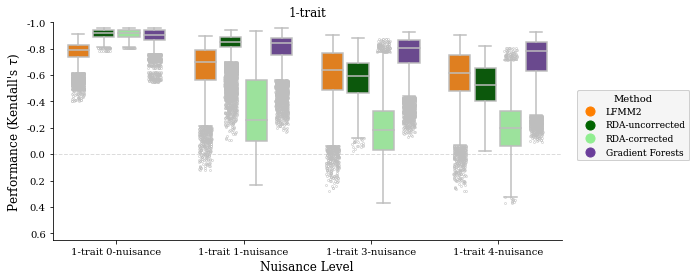

2-trait
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_nuisance-level_by_program.pdf


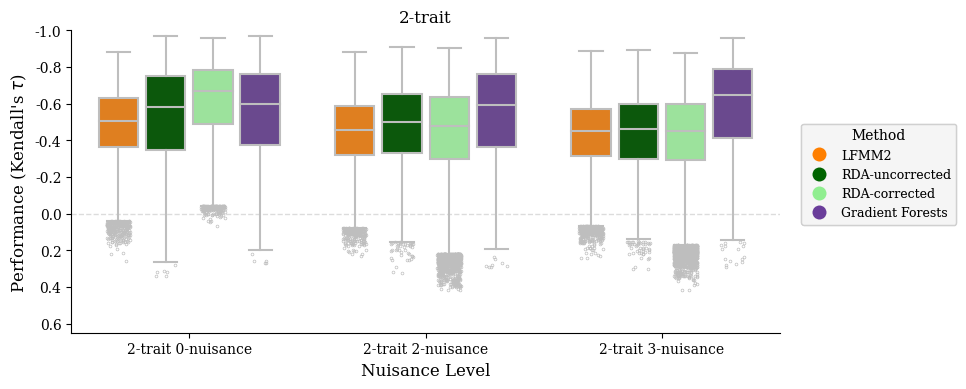

In [15]:
for ntraits in ['1-trait', '2-trait']:
    print(ColorText(ntraits).bold())
    
    df = all_scores[all_scores.plevel == ntraits].copy()
    
    order = sorted(df.nuis_envs.unique())
    
    for hue, hue_order in mvp.hue_order.items():
        if hue != 'program':
            continue
        
        if hue in ['noncausal_env']:
            continue
        if hue in ['slevel', 'pleio'] and ntraits == '1-trait':
            continue
            
        g = sns.catplot(data=df,
                        x='nuis_envs',
                        y='score',
                        order=order,
                        hue=hue,
                        hue_order=hue_order if hue != 'program' else mvp.hue_order[hue],
                        legend=False,
                        kind='box',
                        **mvp.boxplot_kwargs,
                   )
            
        cleanup_fig(g, xlabel='Nuisance Level', bbox_to_anchor=(1, 0.55), color_by=hue, fontsize=9,
                    title=ntraits)

        save_pdf(f'{figdir}/{ntraits}_nuisance-level_by_{hue}.pdf')

        plt.show()


<a id='pbn'></a>
### program by nuisance

[top](#home)

1-trait
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_program_by_nuisance-level.pdf


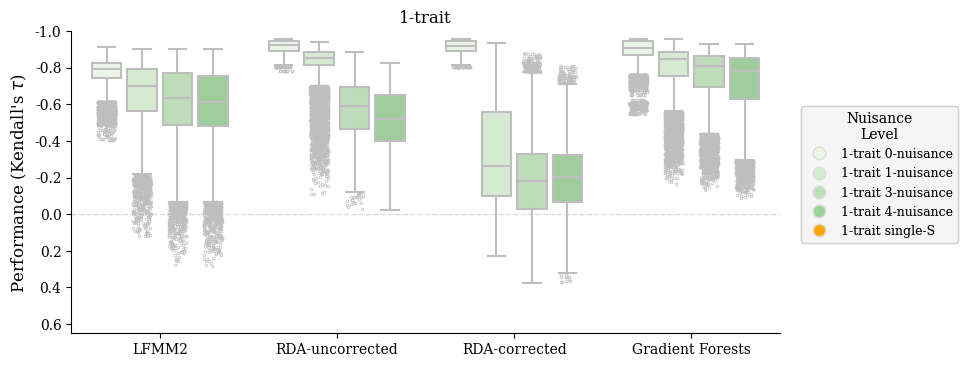

2-trait
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_program_by_nuisance-level.pdf


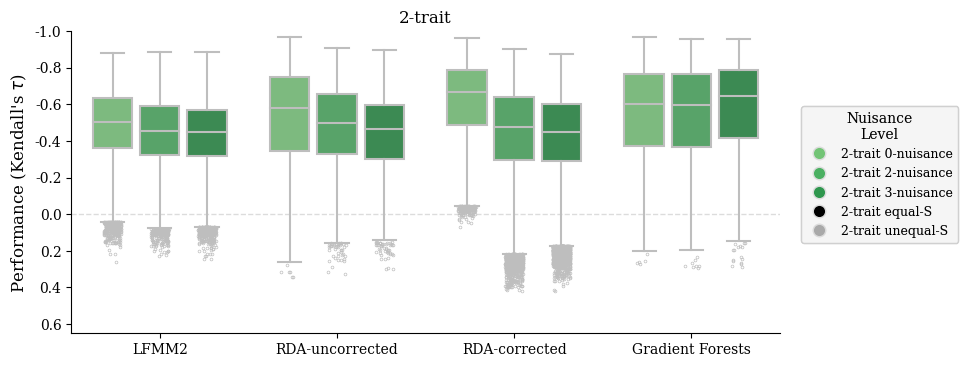

In [16]:
for ntraits in ['1-trait', '2-trait']:
    print(ColorText(ntraits).bold())
    
    df = all_scores[all_scores.plevel == ntraits].copy()
    
    order = sorted(df.nuis_envs.unique())
    
    for hue, hue_order in mvp.hue_order.items():
        if hue != 'program':
            continue
        
        if hue in ['noncausal_env']:
            continue
        if hue in ['slevel', 'pleio'] and ntraits == '1-trait':
            continue
            
        g = sns.catplot(data=df,
                        x=hue,
                        y='score',
                        order=hue_order,# if hue != 'program' else mvp.hue_order[hue],
                        hue='nuis_envs',
                        hue_order=order,
                        legend=False,
                        kind='box',
                        **mvp.boxplot_kwargs,
                   )
        
        g.figure.set_size_inches((8, 4))
        
        cleanup_fig(g, xlabel='Program', bbox_to_anchor=(1, 0.55), color_by=ntraits, fontsize=9,
                    title=ntraits, markeredgecolor='gainsboro')
        
        g.set(xlabel=None)

        save_pdf(f'{figdir}/{ntraits}_{hue}_by_nuisance-level.pdf')
            
        plt.show()
        

<a id='lbn'></a>
### landscape by nuisance

[top](#home)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_landscape_by_nuisance-level.pdf


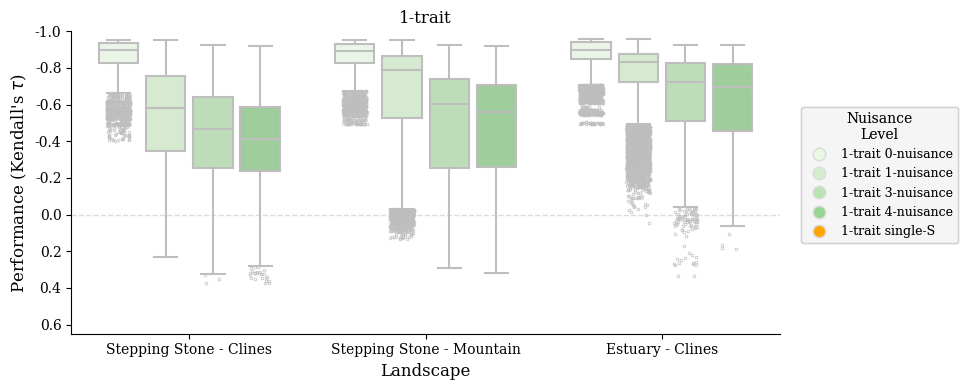

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_landscape_by_nuisance-level.pdf


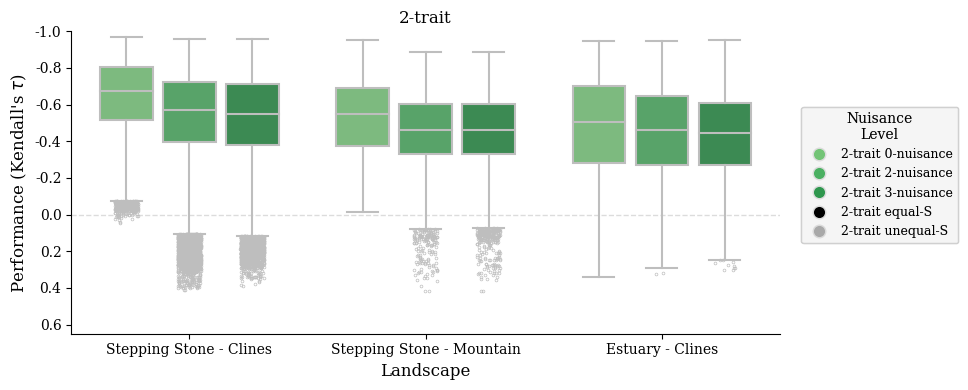

In [17]:
for ntraits in ['1-trait', '2-trait']:
    data = all_scores[all_scores.plevel == ntraits]
    
    g = sns.catplot(
        data=data,
        x='landscape',
        y='score',
        order=mvp.hue_order['landscape'],
        hue='nuis_envs',
        hue_order=sorted(data.nuis_envs.unique()),
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )
    
    cleanup_fig(g, xlabel='Landscape', color_by=ntraits, loc='center left', bbox_to_anchor=(1, 0.55), fontsize=9,
                title=ntraits, markeredgecolor='gainsboro'
               )
    
    save_pdf(f'{figdir}/{ntraits}_landscape_by_nuisance-level.pdf')
    
    plt.show()

<a id='lbpbn'></a>
### landscape by program by nuisance

[top](#home)

In [18]:
def fix_axes_labels(g, x, do_rotation=True):
    
    if x == 'glevel':
        rotation = None
        replace = (' ', '\n')
    elif x == 'popsize':
        rotation = 20
        replace = ('cline-', 'cline\n')
    elif x == 'landscape':
        rotation = 20
        replace = (' - ', '\n')
    elif x == 'nuis_envs':
        rotation = 20
        replace = (' ', '\n')
    else:
        rotation = None
        replace = None
        
    if do_rotation is False:
        rotation=None
    
    for program, ax in zip(mvp.hue_order['program'], g.axes.flat):
        ax.set_ylim((1, -1))
        ax.set(title=mvp.factor_names[program])
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=rotation)
        
    return replace

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_landscape_by_program_by_nuisance-level.pdf


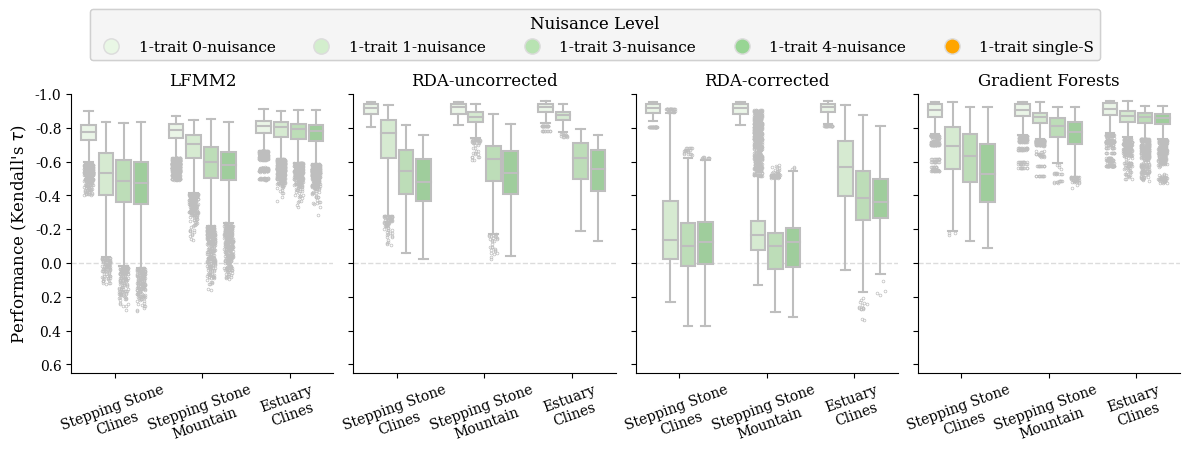

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_landscape_by_program_by_nuisance-level.pdf


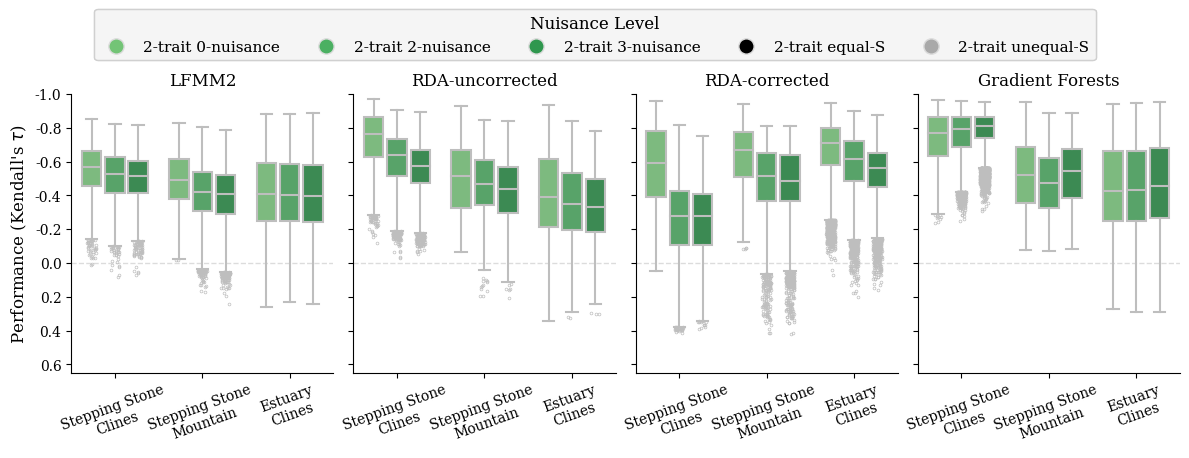

In [19]:
for ntraits in ['1-trait', '2-trait']:
    data = all_scores[all_scores.plevel == ntraits]
    
    g = sns.catplot(
        data=data,
        x='landscape',
        y='score',
        order=mvp.hue_order['landscape'],
        hue='nuis_envs',
        hue_order=sorted(data.nuis_envs.unique()),
        col='program',
        col_order=mvp.hue_order['program'],
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )
    
    replace = fix_axes_labels(g, x='landscape')
    
    cleanup_fig(g, xlabel='Landscape', color_by=ntraits, ncol='auto', loc='upper center',
                bbox_to_anchor=(0.5, 1.14), replace=(' - ', '\n'), fontsize=11, figsize=(12, 4),
                markeredgecolor='gainsboro')
    
    g.set_xlabels('')
    
    save_pdf(f'{figdir}/{ntraits}_landscape_by_program_by_nuisance-level.pdf')
    
    plt.show()

<a id='msbpbn'></a>
### marker set by program by nuisance

[top](#home)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_glevel_by_program_by_nuisance-level.pdf


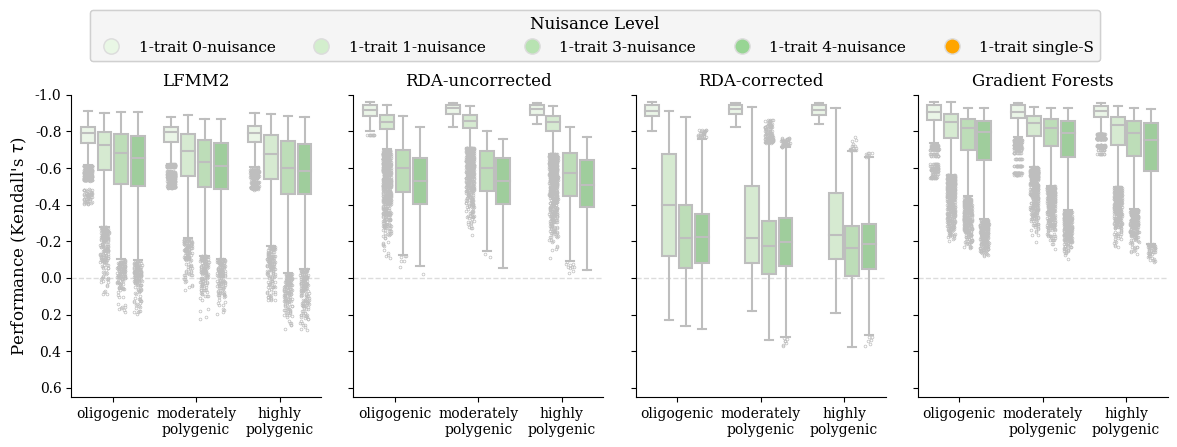

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_popsize_by_program_by_nuisance-level.pdf


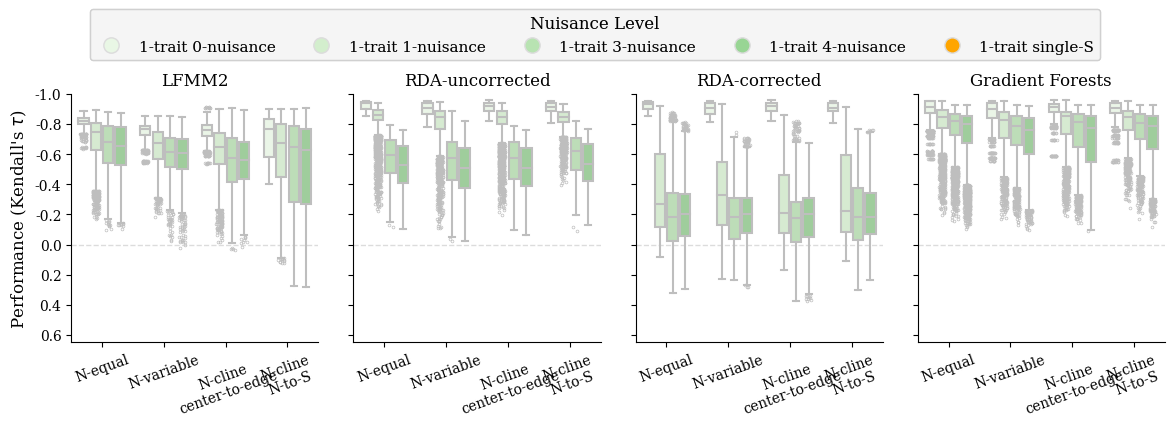

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_migration_by_program_by_nuisance-level.pdf


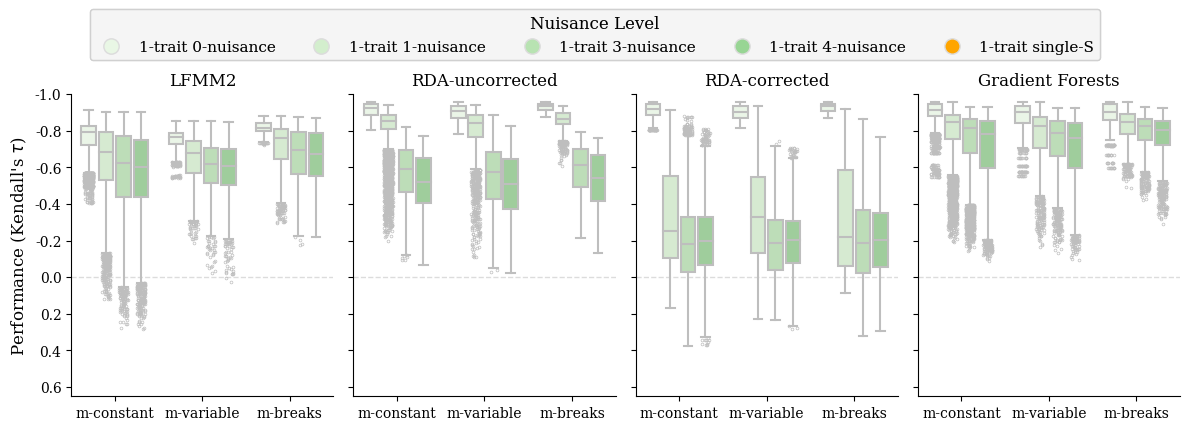

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_marker_set_by_program_by_nuisance-level.pdf


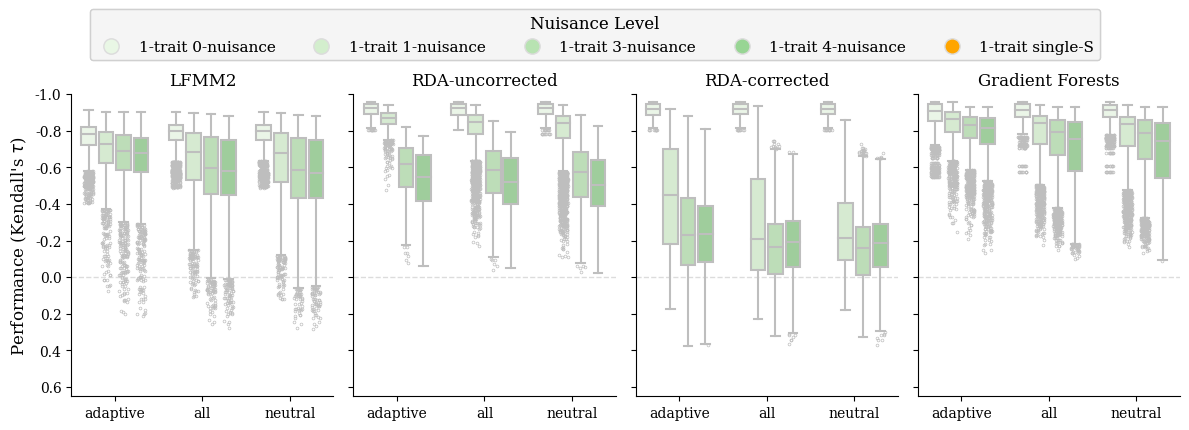

In [20]:
ntraits = '1-trait'

data = all_scores[all_scores.plevel == ntraits]

for x, x_order in mvp.hue_order.items():
    if x in ['landscape', 'program', 'noncausal_env', 'pleio', 'slevel', 'demography']:
        continue
    
    g = sns.catplot(
        data=data,
        x=x,
        y='score',
        order=x_order,
        hue='nuis_envs',
        hue_order=sorted(data.nuis_envs.unique()),
        col='program',
        col_order=mvp.hue_order['program'],
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )

    replace = fix_axes_labels(g, x=x)

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by=ntraits, ncol='auto', loc='upper center',
                bbox_to_anchor=(0.5, 1.14), replace=replace, fontsize=11, figsize=(12, 4),
                markeredgecolor='gainsboro')

    g.set_xlabels('')

    save_pdf(f'{figdir}/{ntraits}_{x}_by_program_by_nuisance-level.pdf')

    plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_glevel_by_program_by_nuisance-level.pdf


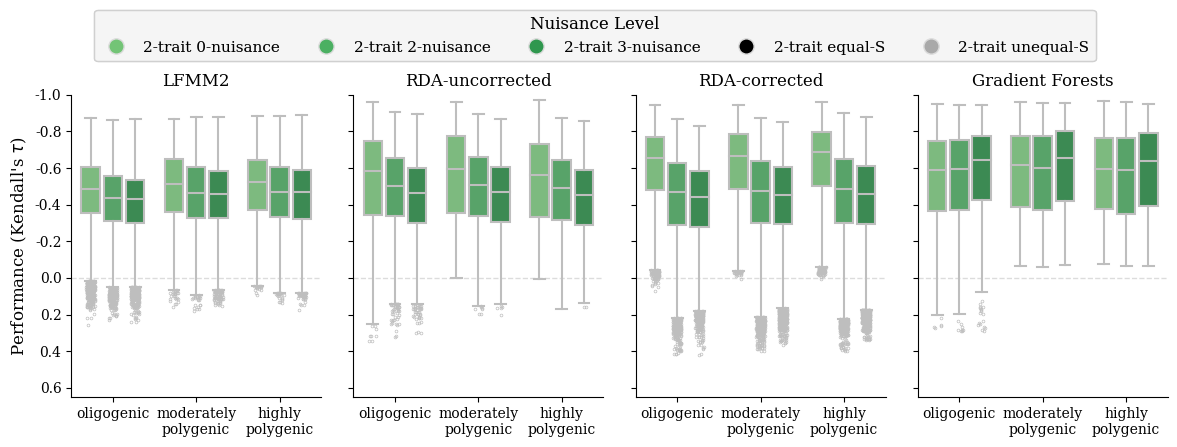

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_pleio_by_program_by_nuisance-level.pdf


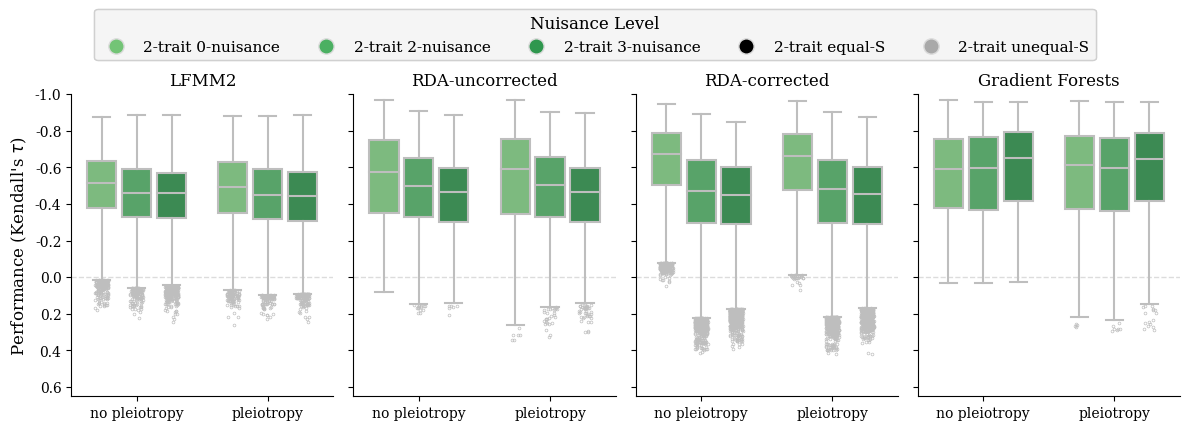

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_slevel_by_program_by_nuisance-level.pdf


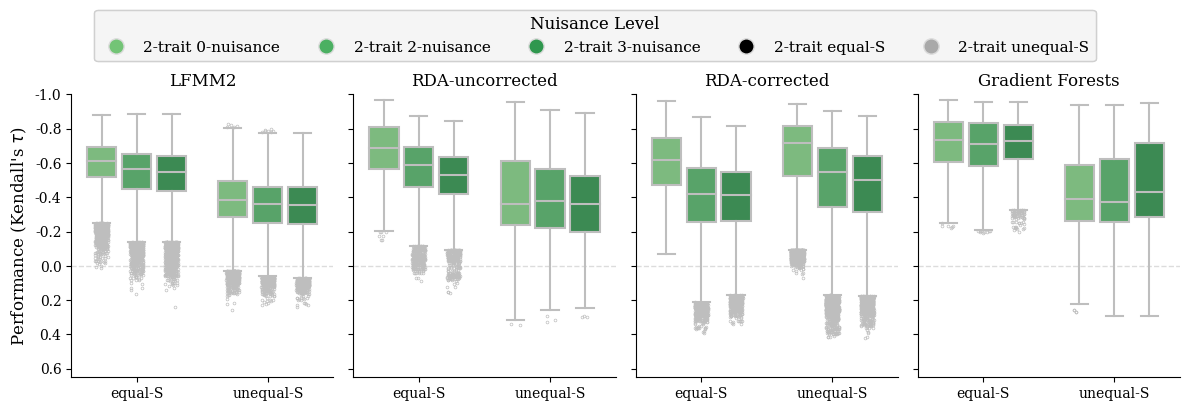

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_popsize_by_program_by_nuisance-level.pdf


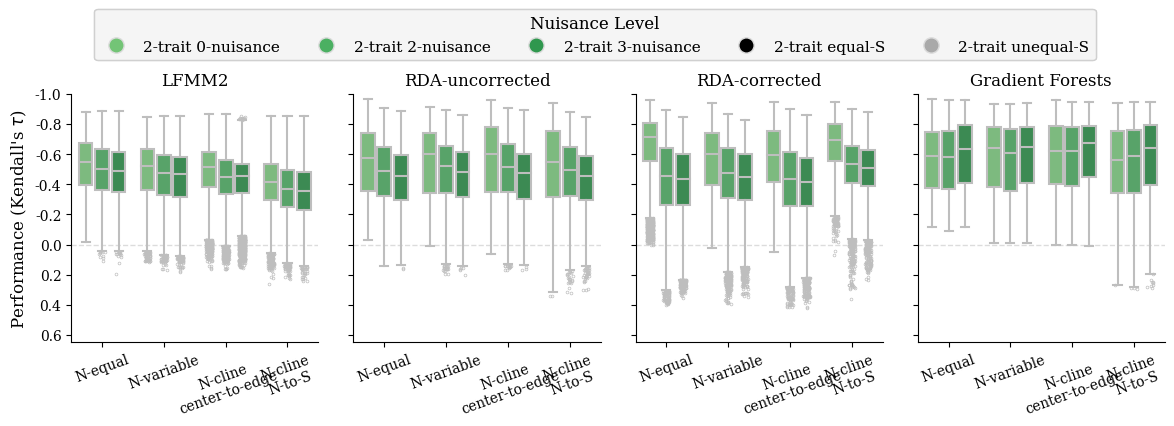

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_migration_by_program_by_nuisance-level.pdf


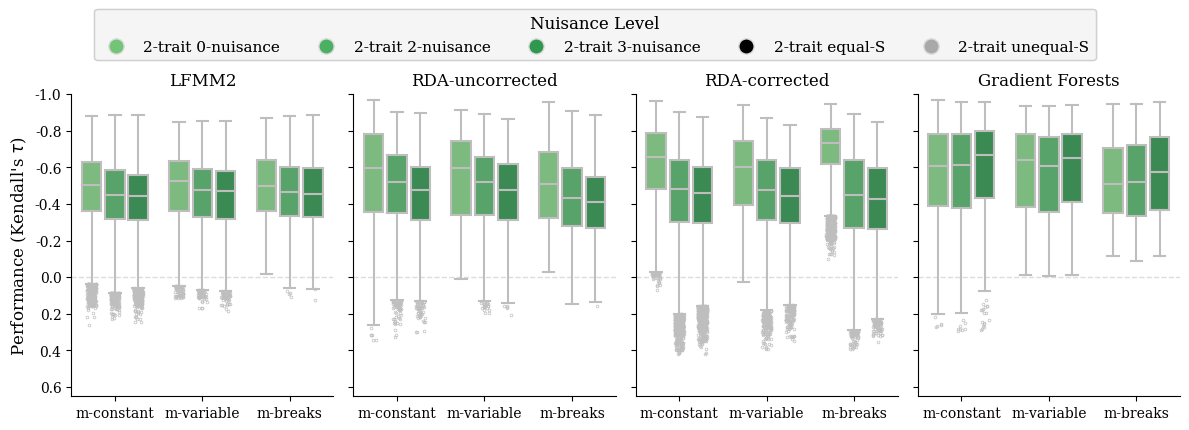

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_marker_set_by_program_by_nuisance-level.pdf


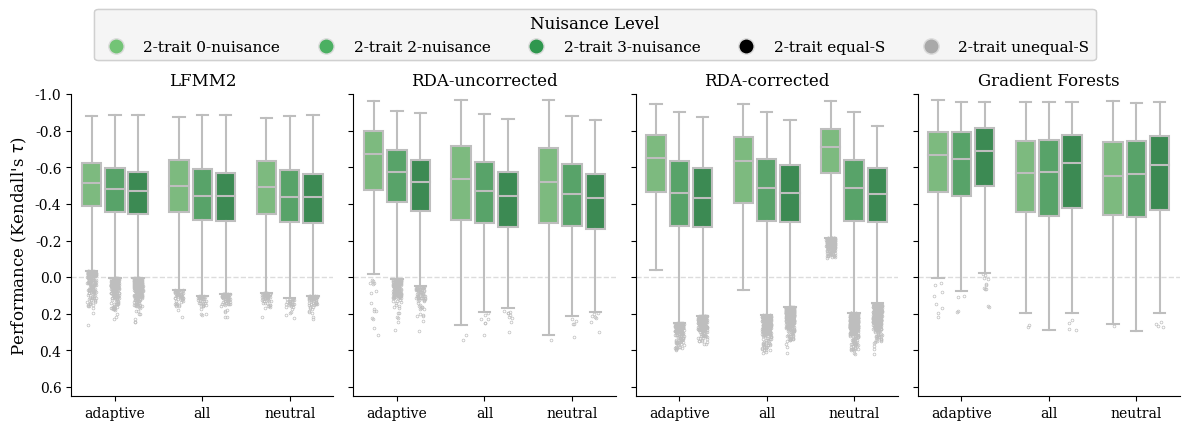

In [21]:
ntraits = '2-trait'

data = all_scores[all_scores.plevel == ntraits]

for x, x_order in mvp.hue_order.items():
    if x in ['landscape', 'program', 'noncausal_env', 'demography']:
        continue
    
    g = sns.catplot(
        data=data,
        x=x,
        y='score',
        order=x_order,
        hue='nuis_envs',
        hue_order=sorted(data.nuis_envs.unique()),
        col='program',
        col_order=mvp.hue_order['program'],
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )

    replace = fix_axes_labels(g, x=x)

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by=ntraits, ncol='auto', loc='upper center',
                bbox_to_anchor=(0.5, 1.14), replace=replace, fontsize=11, figsize=(12, 4),
                markeredgecolor='gainsboro')

    g.set_xlabels('')

    save_pdf(f'{figdir}/{ntraits}_{x}_by_program_by_nuisance-level.pdf')

    plt.show()

<a id='nbpbms'></a>
### nuisance by program by marker set

[top](#home)

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_nuisance_by_program_by_glevel.pdf


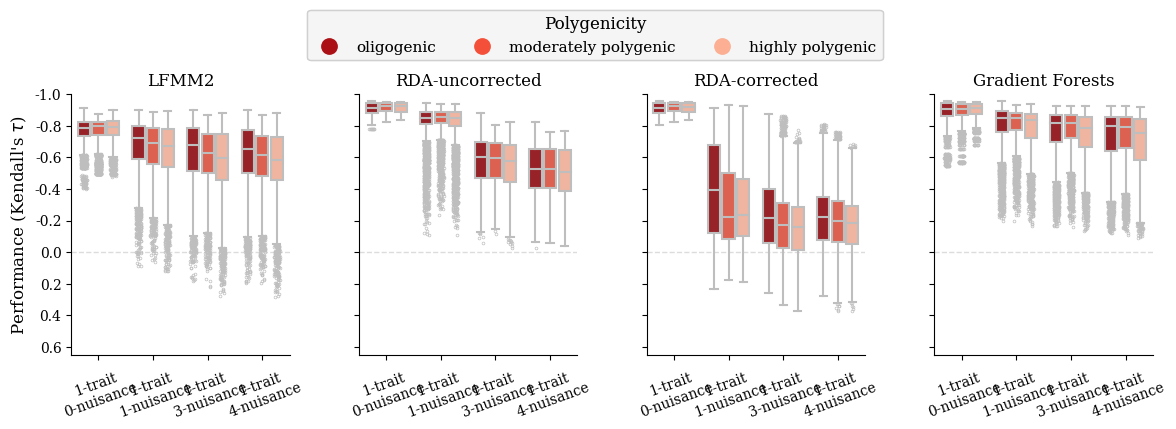

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_nuisance_by_program_by_popsize.pdf


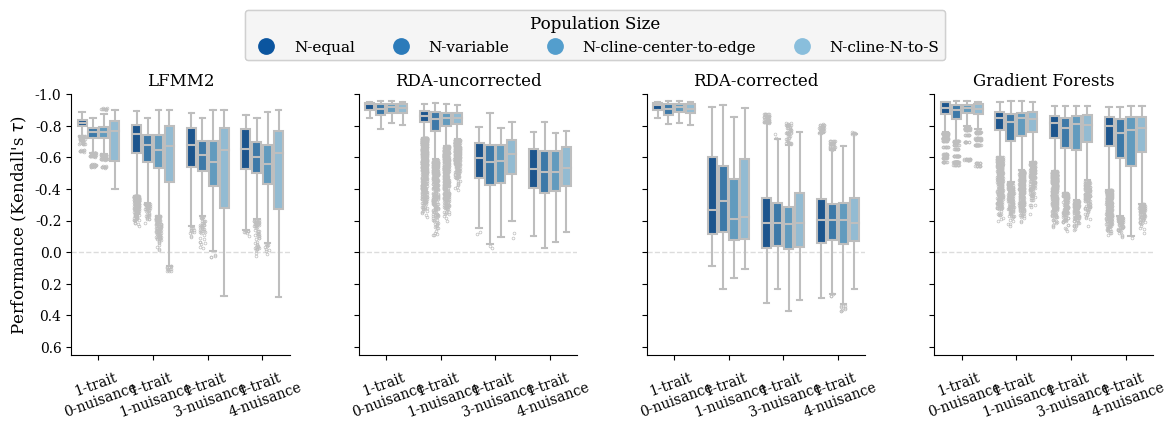

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_nuisance_by_program_by_migration.pdf


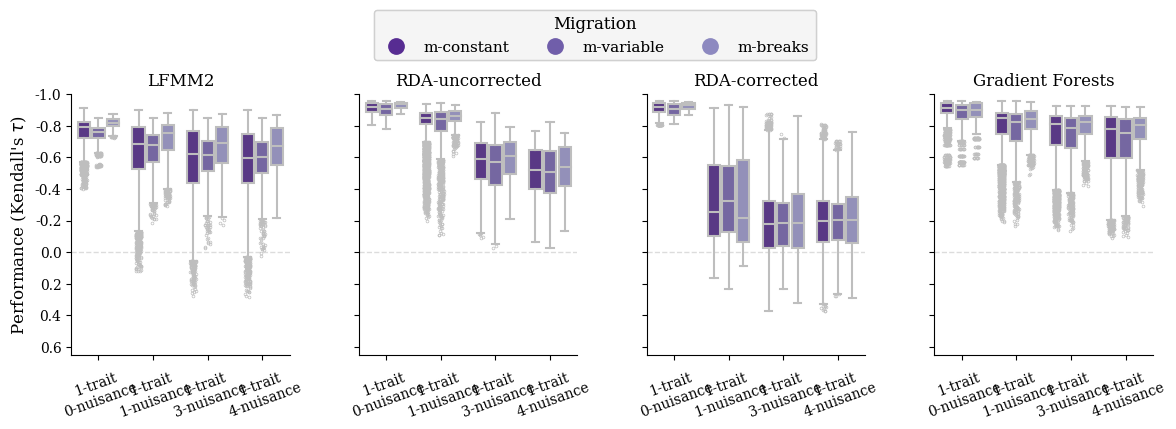

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/1-trait_nuisance_by_program_by_marker_set.pdf


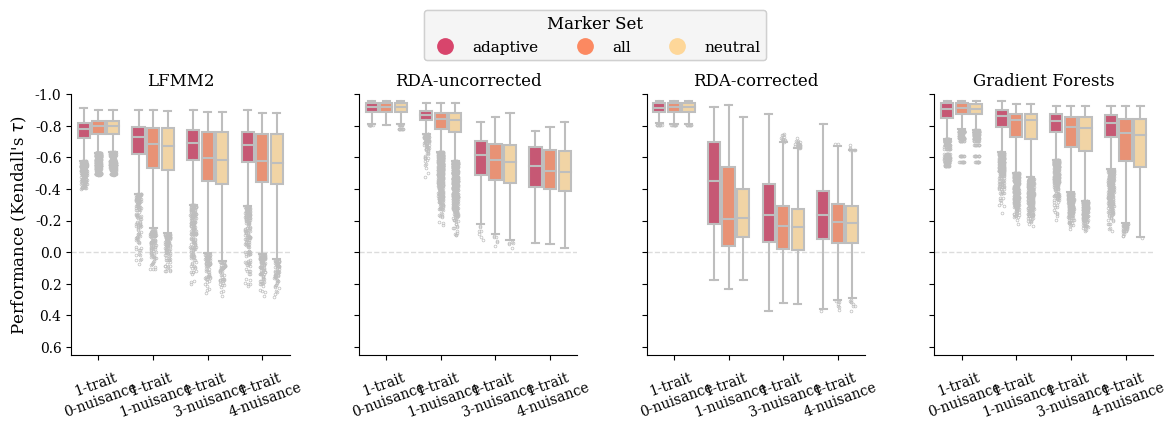

In [22]:
ntraits = '1-trait'

data = all_scores[all_scores.plevel == ntraits]

for x, x_order in mvp.hue_order.items():
    if x in ['landscape', 'program', 'noncausal_env', 'pleio', 'slevel', 'demography']:
        continue
    
    g = sns.catplot(
        data=data,
        x='nuis_envs',
        y='score',
        order=sorted(data.nuis_envs.unique()),
        hue=x,
        hue_order=x_order,
        col='program',
        col_order=mvp.hue_order['program'],
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )

    replace = fix_axes_labels(g, x='nuis_envs')

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by=x, ncol='auto', loc='upper center',
                bbox_to_anchor=(0.5, 1.14), replace=replace, fontsize=11, figsize=(12, 4))

    g.set_xlabels('')

    save_pdf(f'{figdir}/{ntraits}_nuisance_by_program_by_{x}.pdf')

    plt.show()

In [ ]:
Hi Katie,

This letter is due January 15. Here is the job ad - https://recruit.ap.ucsb.edu/JPF02635

Thanks again!

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_nuisance_by_program_by_glevel.pdf


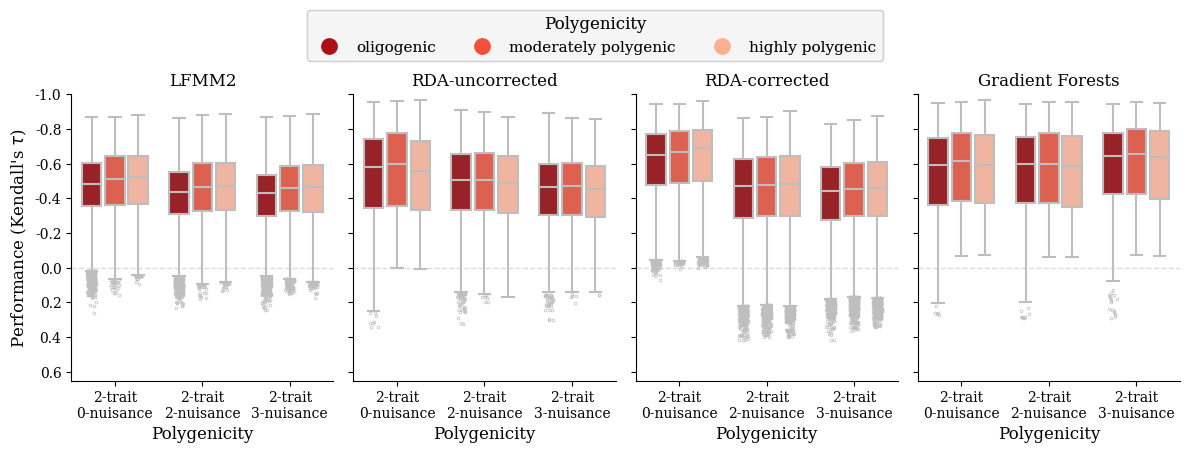

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_nuisance_by_program_by_popsize.pdf


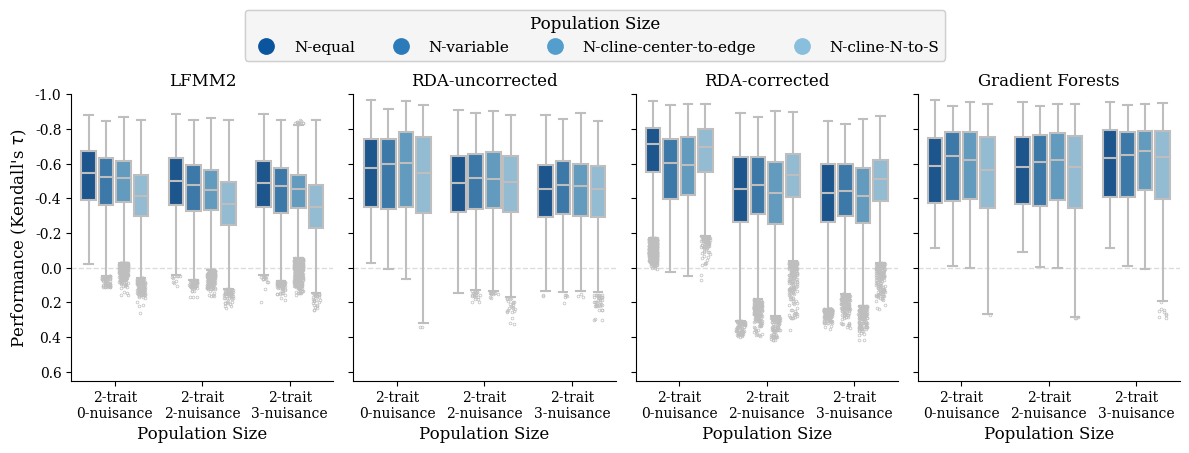

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_nuisance_by_program_by_migration.pdf


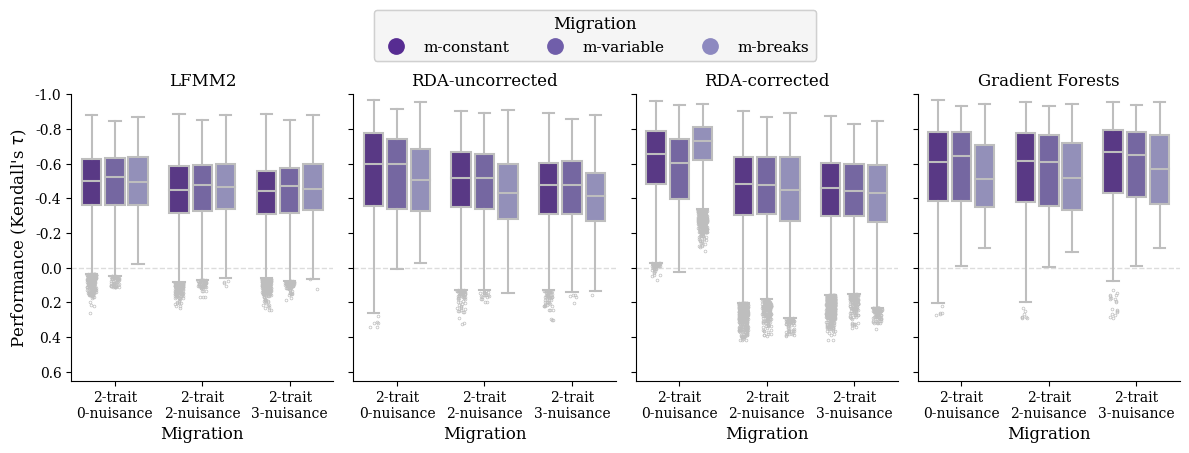

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_nuisance_by_program_by_marker_set.pdf


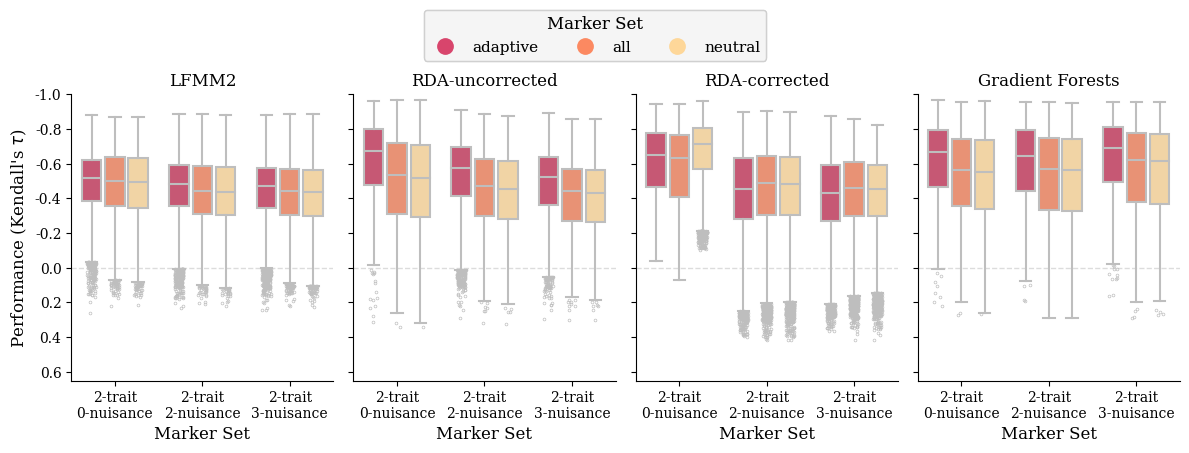

In [23]:
ntraits = '2-trait'

data = all_scores[all_scores.plevel == ntraits]

for x, x_order in mvp.hue_order.items():
    if x in ['landscape', 'program', 'noncausal_env', 'pleio', 'slevel', 'demography']:
        continue
    
    g = sns.catplot(
        data=data,
        x='nuis_envs',
        y='score',
        order=sorted(data.nuis_envs.unique()),
        hue=x,
        hue_order=x_order,
        col='program',
        col_order=mvp.hue_order['program'],
        kind='box',
        legend=False,
        **mvp.boxplot_kwargs
    )

    replace = fix_axes_labels(g, x='nuis_envs', do_rotation=False)
    
    g.set_xlabels('')

    cleanup_fig(g, xlabel=mvp.factor_names[x], color_by=x, ncol='auto', loc='upper center',
                bbox_to_anchor=(0.5, 1.14), replace=replace, fontsize=11, figsize=(12, 4))
    
    plt.tight_layout()  # not sure why I need to do this again after cleanup_fig?

    save_pdf(f'{figdir}/{ntraits}_nuisance_by_program_by_{x}.pdf')

    plt.show()

# 2d histograms

In [24]:
all_scores.nuis_envs.value_counts()

2-trait 0-nuisance    216000
2-trait 2-nuisance    216000
2-trait 3-nuisance    216000
1-trait 0-nuisance     54000
1-trait 1-nuisance     54000
1-trait 3-nuisance     54000
1-trait 4-nuisance     54000
Name: nuis_envs, dtype: int64

### all programs combined

In [25]:
def create_histo_box(diffs, file_prefix):
    # create histoboxes 
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8, 3))
    for ax, (marker_combo, diff) in zip(axes, diffs.items()):
        marker_set_i, marker_set_j = marker_combo.split('-')
        ax_box, ax_hist = histo_box(
            data=diff,
            xlim=(-1, 1),
            xticks_by=0.5,
            title=f'$\it{marker_set_i}$ - $\it{marker_set_j}$',
            histbins=20,
            ax=ax,
            ticksize=8,
            boxplot_kws={'flierprops' : {'marker' : '.'}},
            markersize=3
        )
        
        mvp.jitter_fliers(axes=[ax_box], jitter_axis='y', jit=0.3)
        
#     fig.suptitle(nuis_level, y=0.87, ha='center')
    fig.supxlabel('Performance difference', y=0.05)
    plt.tight_layout()
    save_pdf(f'{figdir}/{file_prefix}histobox_diffs.pdf')
    plt.show()
    
    pass

In [26]:
def get_index(df, marker_set):
    """Get a unique name for comparing later."""
    index = df[
        ['offset_level', 'program', 'garden', 'seed']
    ].astype(str)\
        .agg('_'.join, axis=1)\
        .str.replace(' ', '-')\
        .str.replace(f'_{marker_set}_', '_')  # remove marker set name 
    
    assert luni(index) == nrow(df)
    
    return index

def calc_diff(nuis_data, file_filler='', bins=45):
    diffs = {}
    for marker_set_i, marker_set_j in it.combinations(mvp.hue_order['marker_set'], r=2):
        i_df = nuis_data[nuis_data.marker_set == marker_set_i].reset_index(drop=True)
        j_df = nuis_data[nuis_data.marker_set == marker_set_j].reset_index(drop=True)

        good_scores = i_df.score.notnull() & j_df.score.notnull()

        perc = sum(i_df.loc[good_scores].score < j_df.loc[good_scores].score) / nrow(j_df)
        perc = '{:.2f}'.format(perc * 100)

#         print(f'f$\it{marker_set_i}$ outperforms $\it{marker_set_j}$ {perc}%')

        ax = scatter2d(
            x=i_df.loc[good_scores].score,
            y=j_df.loc[good_scores].score,
            title=f'{perc}% of $\it{marker_set_i}$ models outperform $\it{marker_set_j}$ models\n{nuis_level}',  # "% of X models outperform Y models
            marginal_kws={'color' : 'gray', 'bins' : bins},
            bins=bins,
            cmap='magma'
        )

        draw_xy(ax.ax_joint)

        ax.ax_joint.set_xlabel(marker_set_i, style='italic')
        ax.ax_joint.set_ylabel(marker_set_j, style='italic')

        ax.ax_joint.invert_xaxis()
        ax.ax_joint.invert_yaxis()

        nuis_name = nuis_level.replace(' ', '_')

        pdf = f'{figdir}/{nuis_name}_{file_filler}scatter2d_{marker_set_i}_{marker_set_j}.pdf'
        save_pdf(pdf)

        plt.show()
        
        # data for histo box
        set1 = i_df.loc[good_scores]
        set2 = j_df.loc[good_scores]
        index1 = get_index(set1, marker_set_i)
        index2 = get_index(set2, marker_set_j)
        assert all(index1 == index2)
        
        diff_series = set1.score - set2.score
        diff_series.index = index1.tolist()
        diffs[f'{marker_set_i}-{marker_set_j}'] = diff_series

    # create histoboxes 
    create_histo_box(diffs, file_prefix=f'{nuis_name}_{file_filler}')
    
    return diffs

def calc_nuis_diffs(hue=None):
    all_diffs = defaultdict(dict)
    for nuis_level in all_scores.nuis_envs.sort_values().unique():
        if '0-nuisance' in nuis_level:
            continue

        nuis_df = all_scores[all_scores.nuis_envs == nuis_level].copy()
        
        if hue is not None:
            for element in mvp.hue_order[hue]:
                nuis_data = nuis_df[nuis_df[hue] == element].copy()
                all_diffs[nuis_level][f'{hue}_{element}'] = calc_diff(nuis_data, file_filler=f'{element}_')
        else:
            all_diffs[nuis_level][hue] = calc_diff(nuis_df, file_filler='')
        
    return all_diffs

### everything all together

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_all.pdf


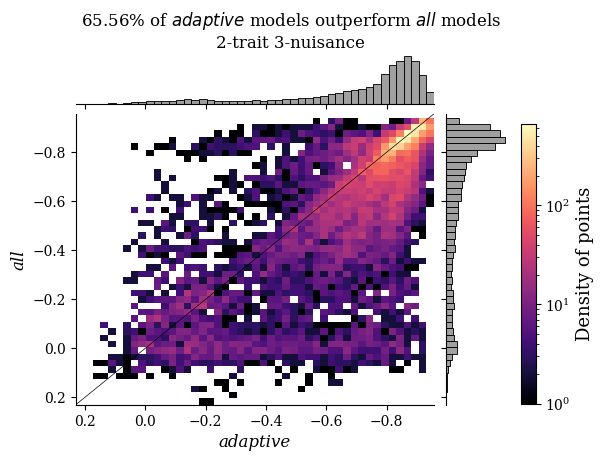

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_neutral.pdf


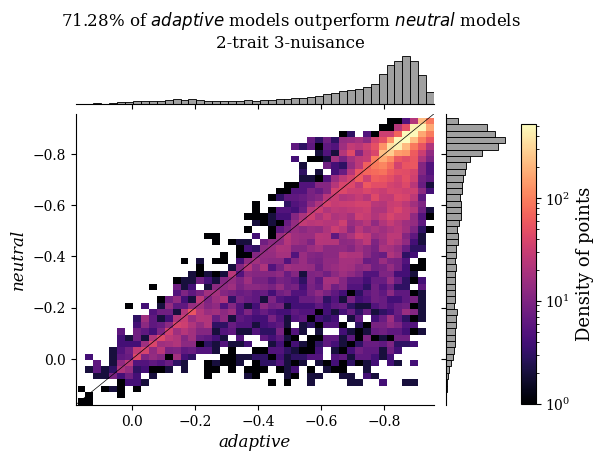

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_all_neutral.pdf


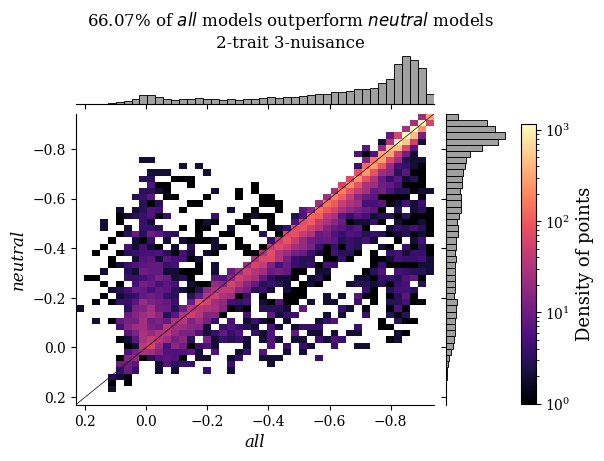

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_histobox_diffs.pdf


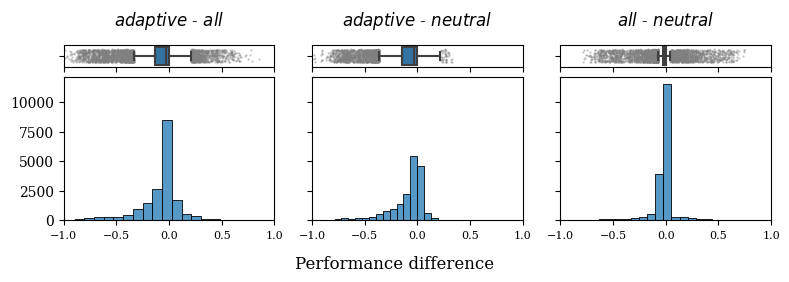

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_all.pdf


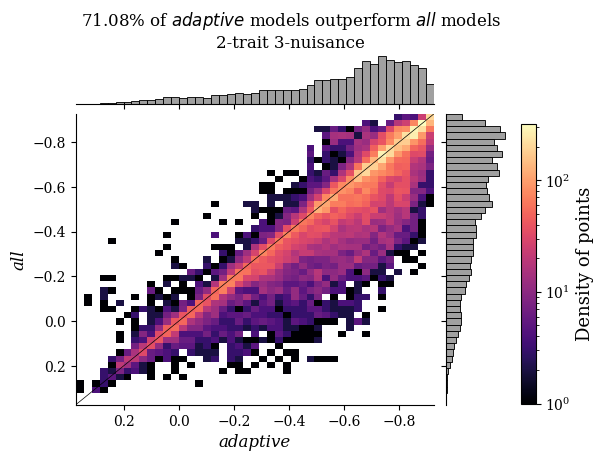

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_neutral.pdf


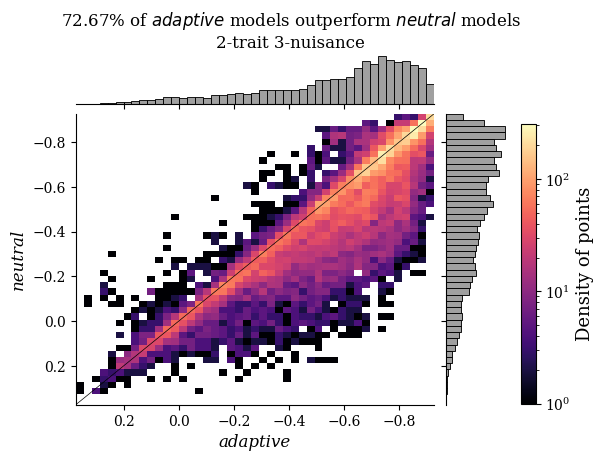

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_all_neutral.pdf


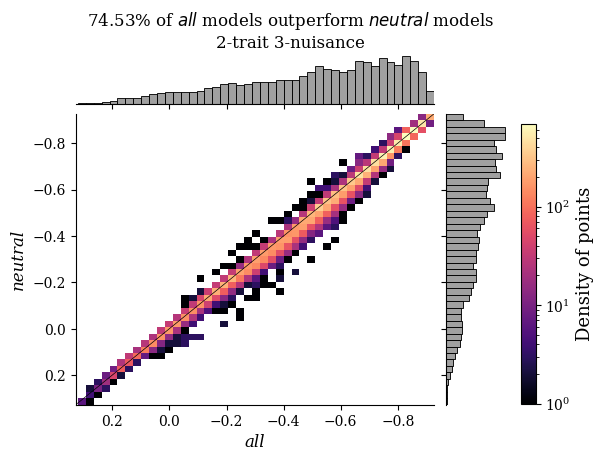

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_histobox_diffs.pdf


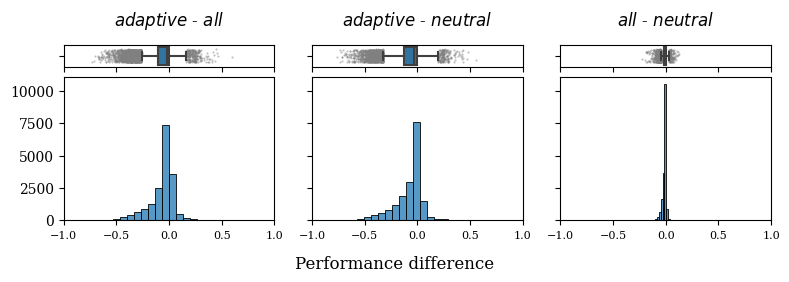

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_all.pdf


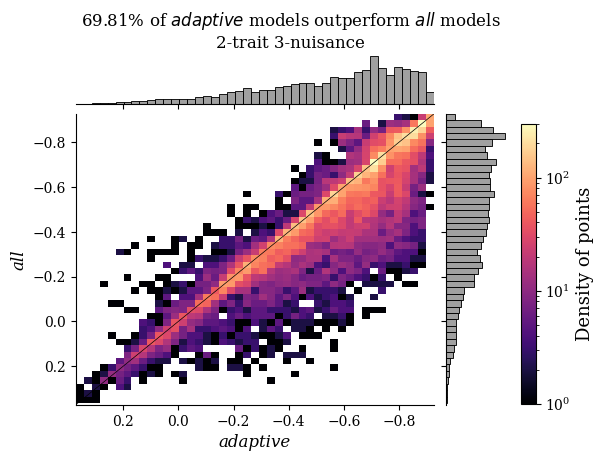

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_neutral.pdf


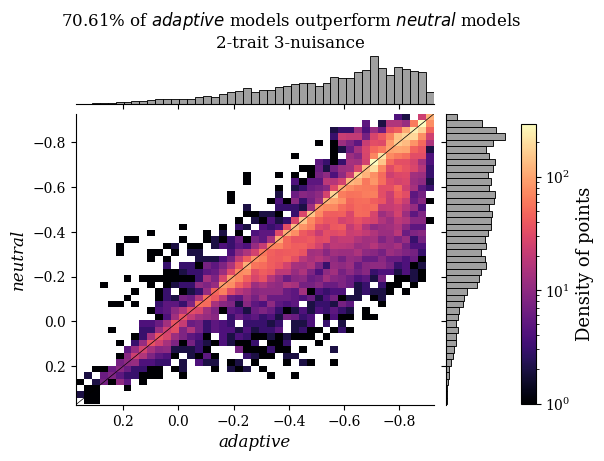

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_all_neutral.pdf


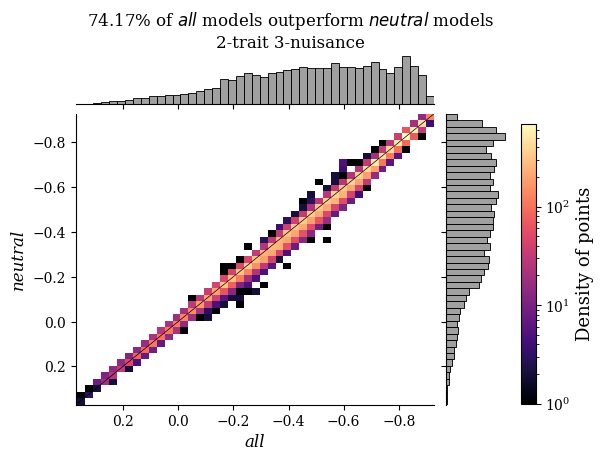

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_histobox_diffs.pdf


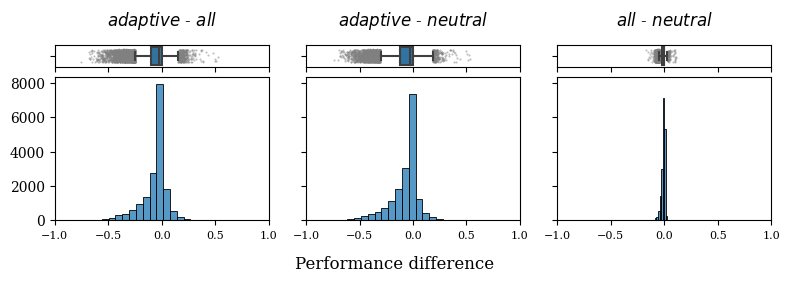

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_all.pdf


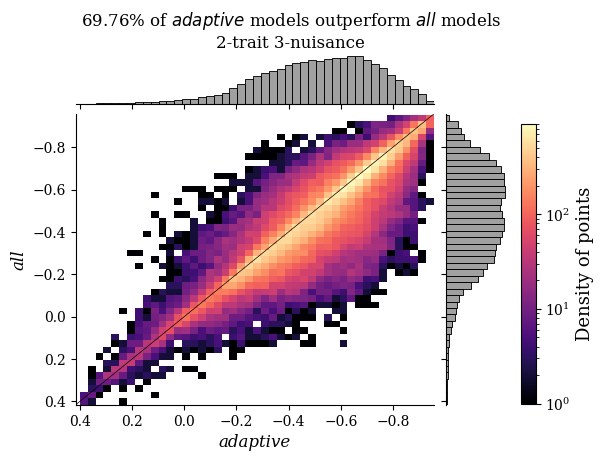

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_neutral.pdf


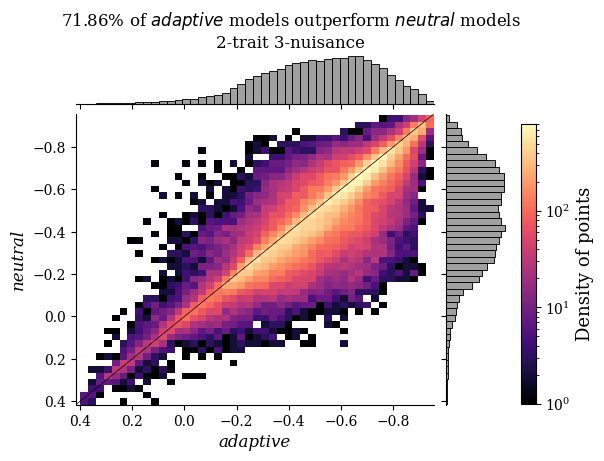

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_all_neutral.pdf


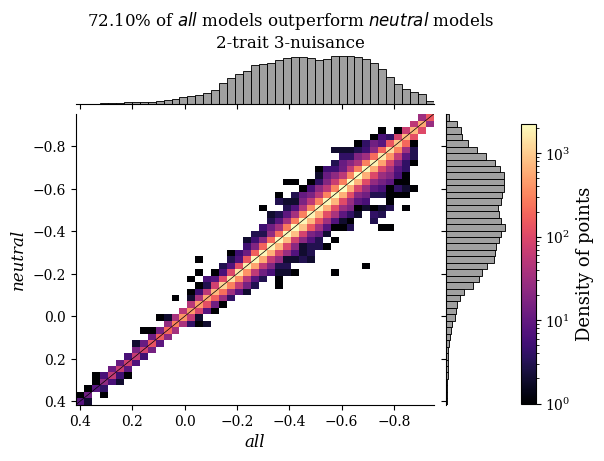

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_histobox_diffs.pdf


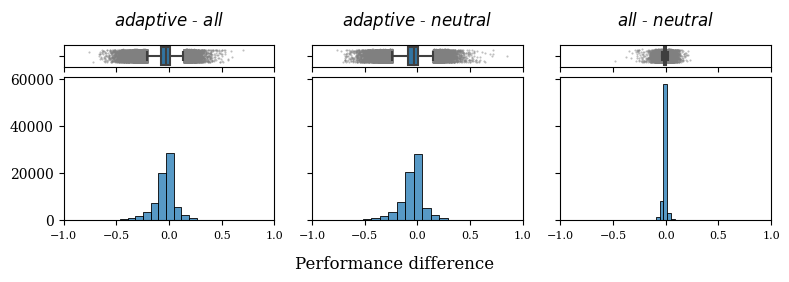

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_all.pdf


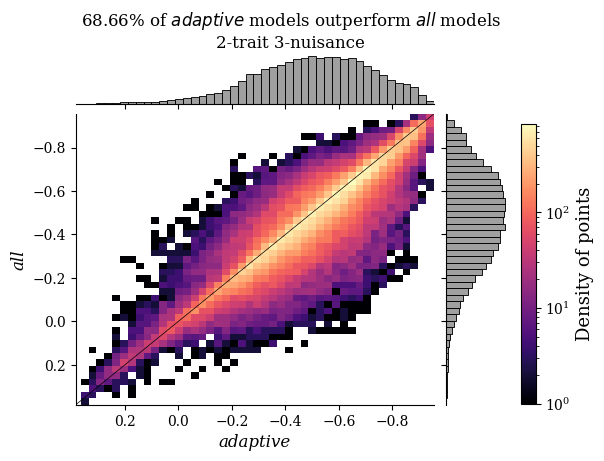

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_adaptive_neutral.pdf


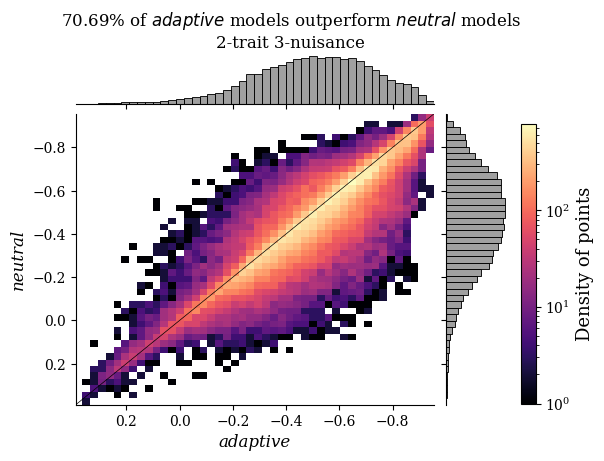

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_scatter2d_all_neutral.pdf


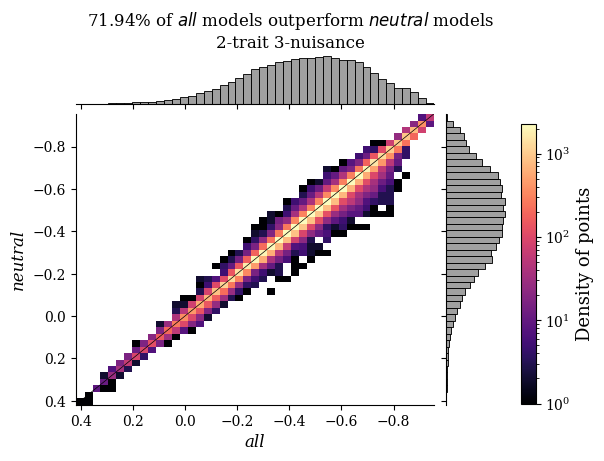

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_histobox_diffs.pdf


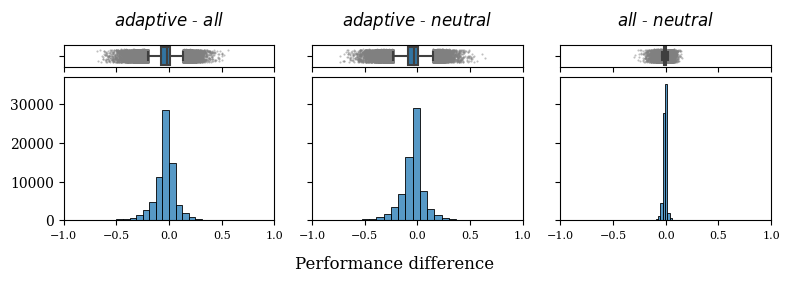

In [27]:
diffs = calc_nuis_diffs()

In [28]:
diffs['1-trait 1-nuisance'][None]['adaptive-all'].index[0]

'highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_1_1231094'

### separated by program

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_all.pdf


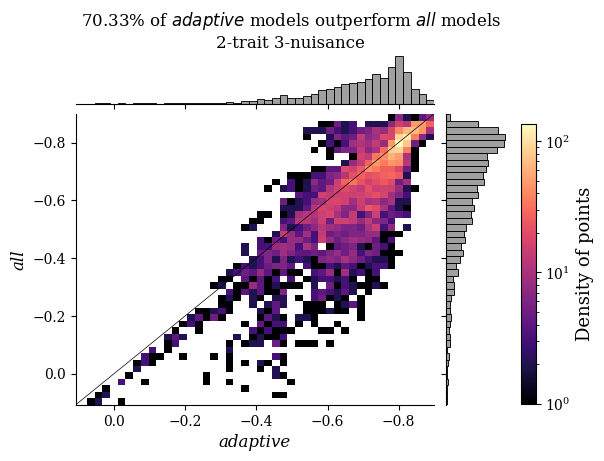

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_neutral.pdf


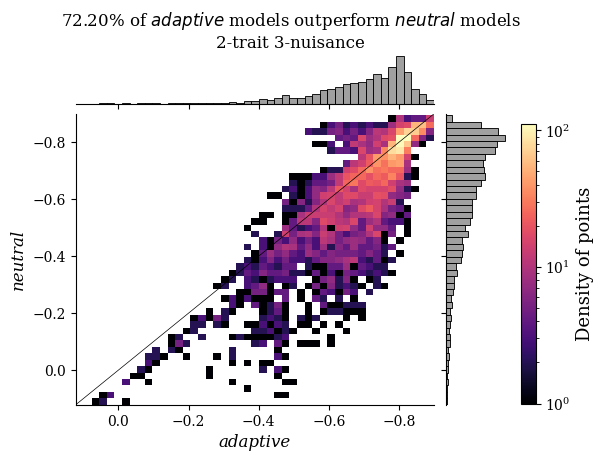

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_all_neutral.pdf


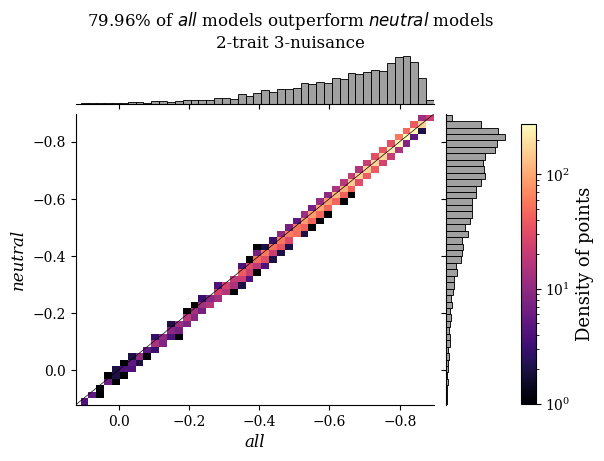

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_histobox_diffs.pdf


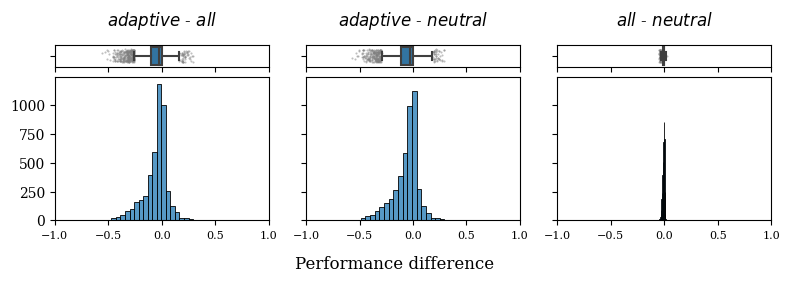

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_all.pdf


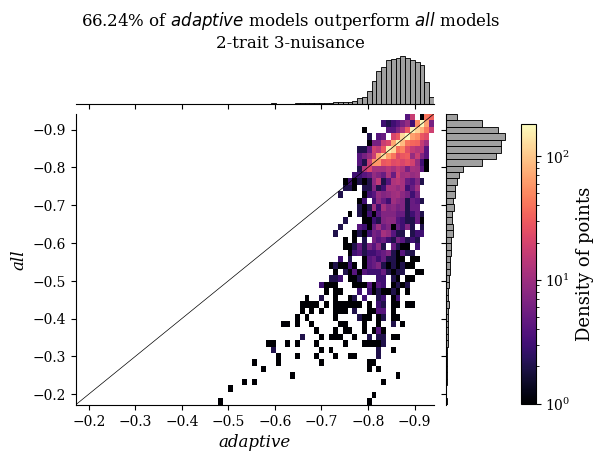

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_neutral.pdf


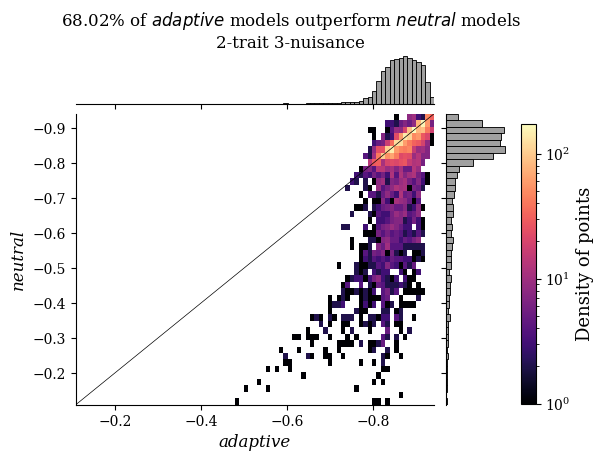

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_all_neutral.pdf


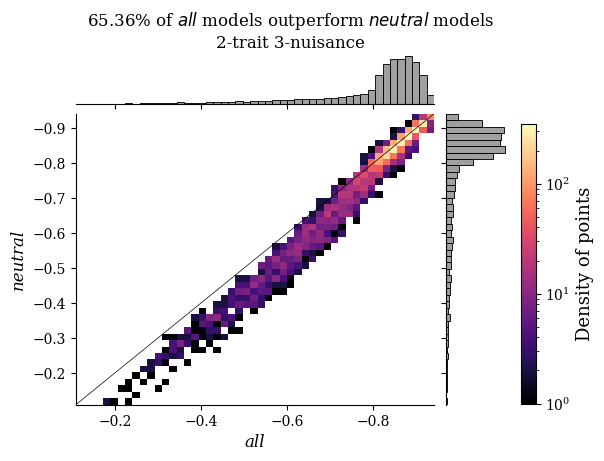

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_histobox_diffs.pdf


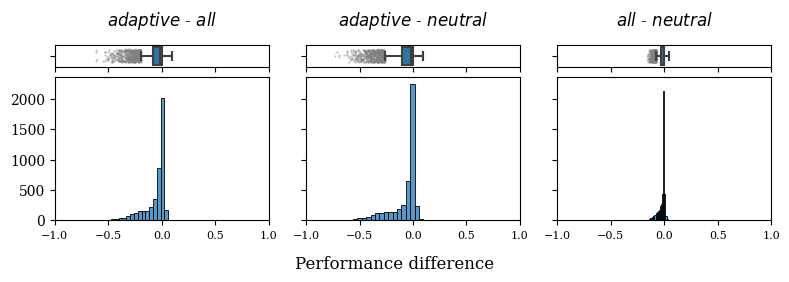

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_all.pdf


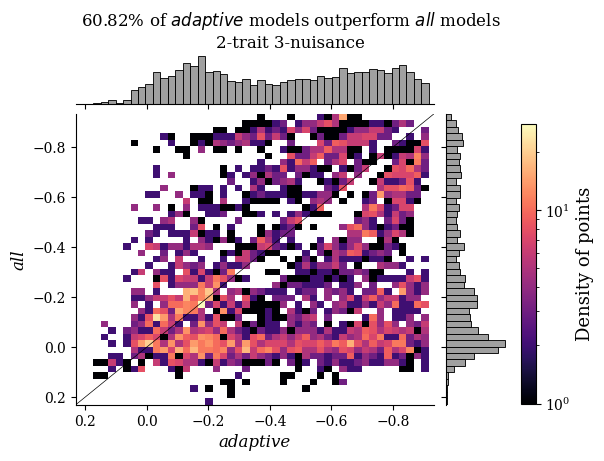

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_neutral.pdf


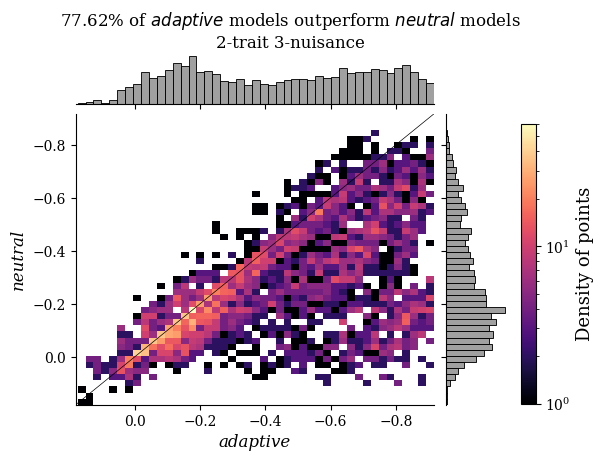

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_all_neutral.pdf


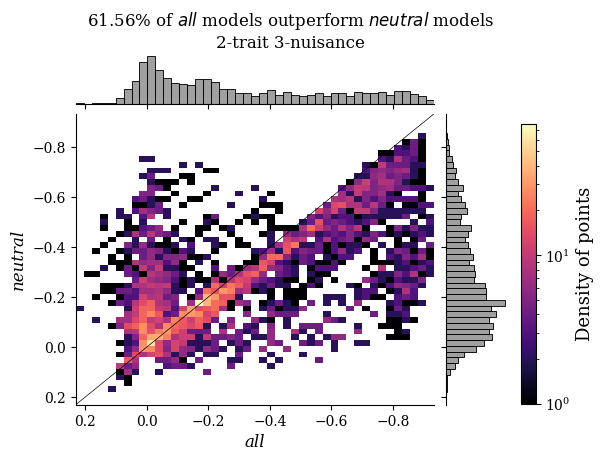

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_histobox_diffs.pdf


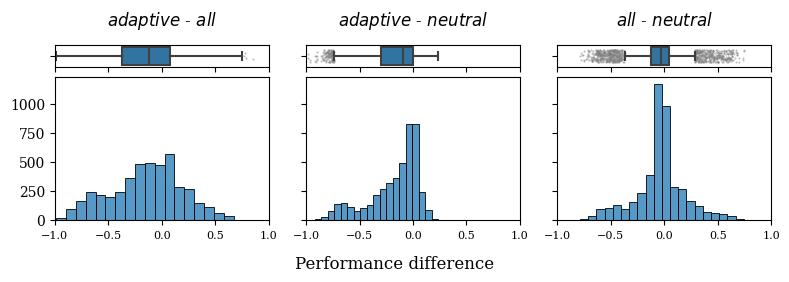

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_all.pdf


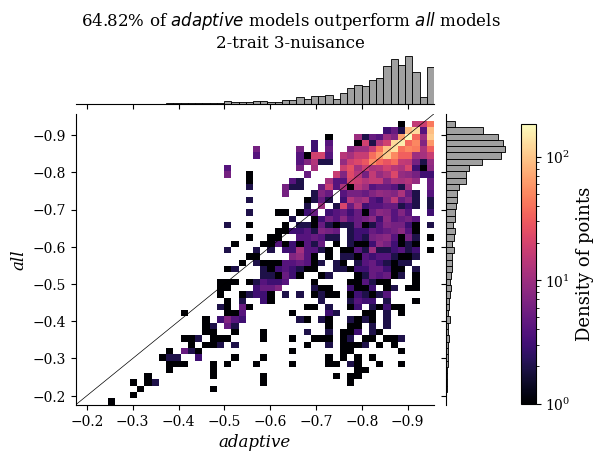

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_neutral.pdf


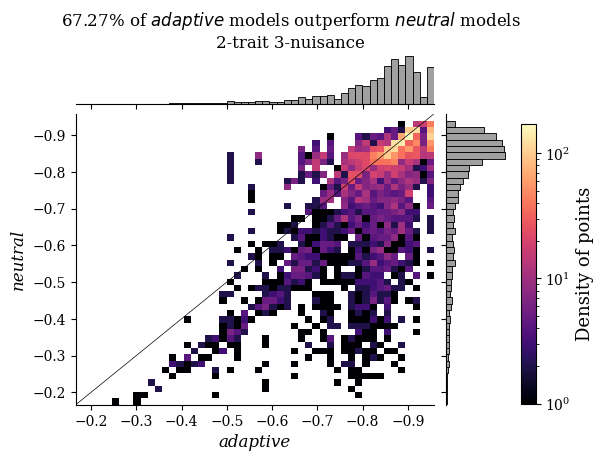

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_all_neutral.pdf


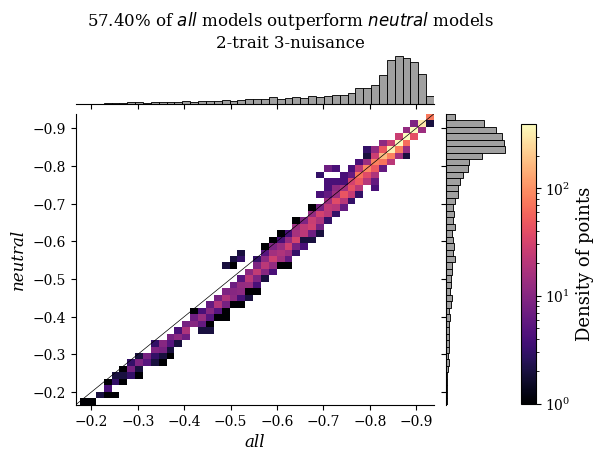

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_histobox_diffs.pdf


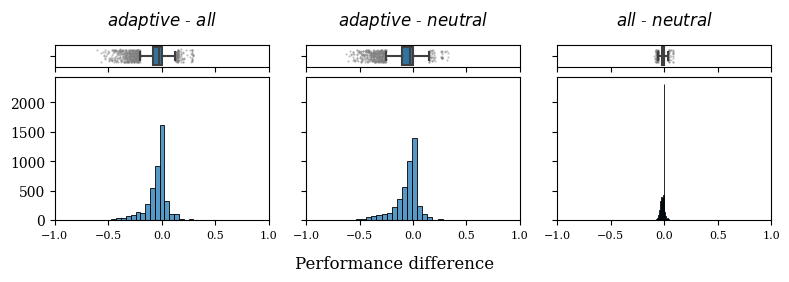

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_all.pdf


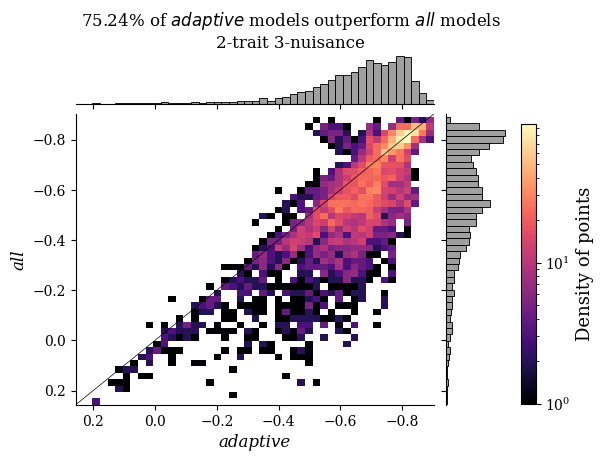

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_neutral.pdf


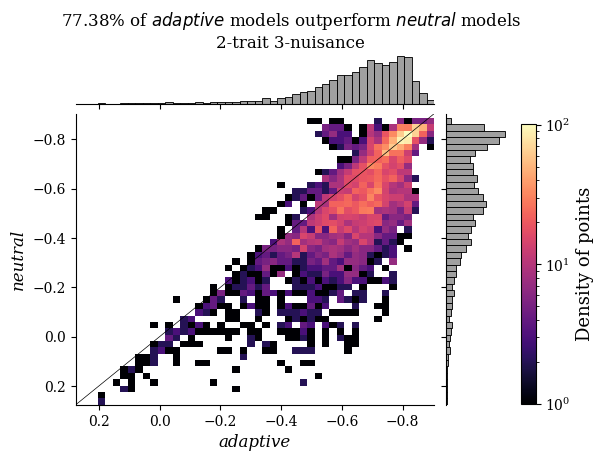

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_all_neutral.pdf


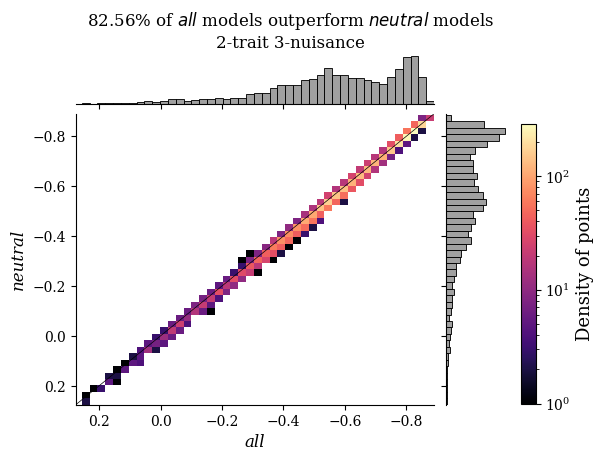

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_histobox_diffs.pdf


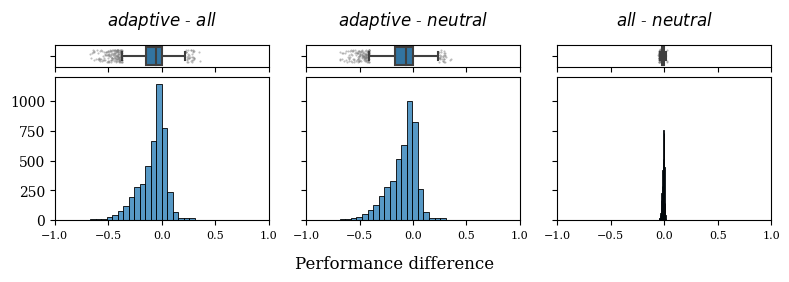

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_all.pdf


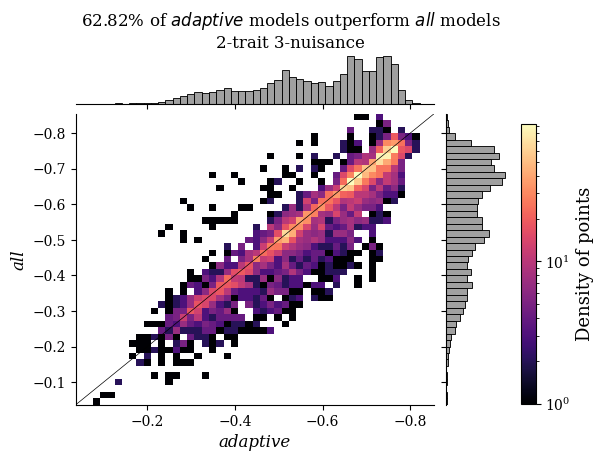

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_neutral.pdf


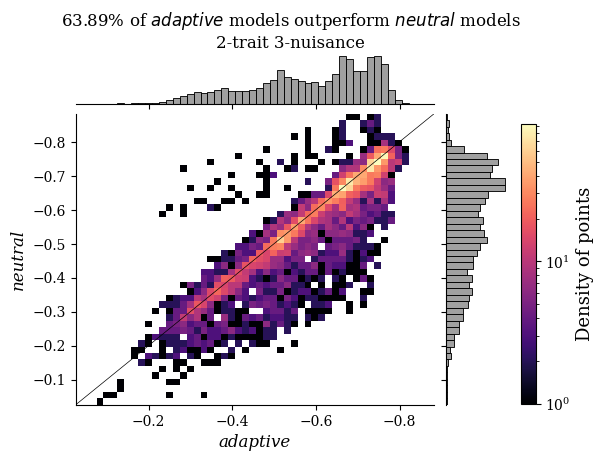

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_all_neutral.pdf


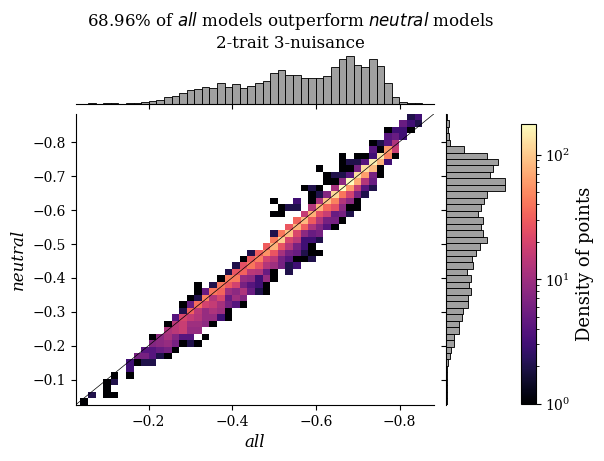

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_histobox_diffs.pdf


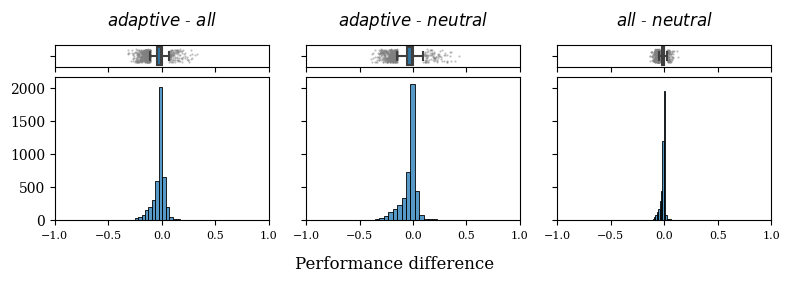

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_all.pdf


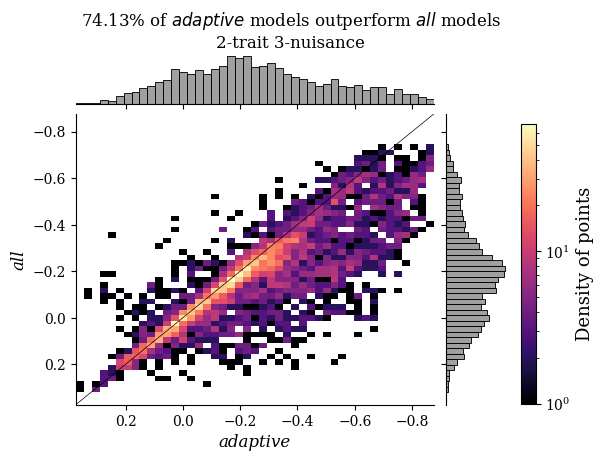

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_neutral.pdf


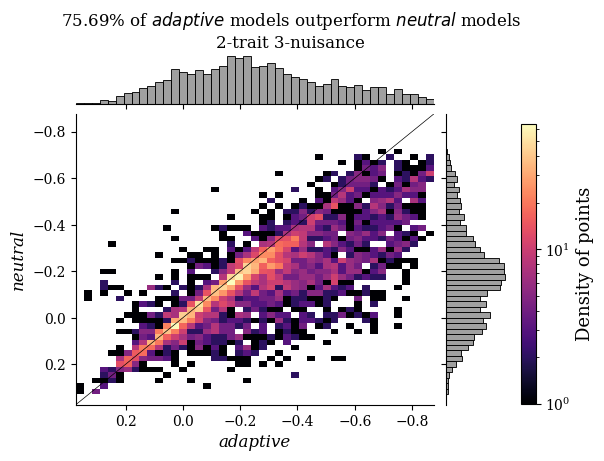

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_all_neutral.pdf


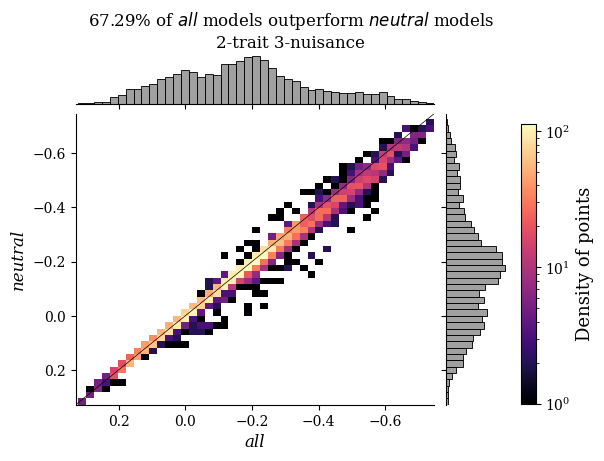

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_histobox_diffs.pdf


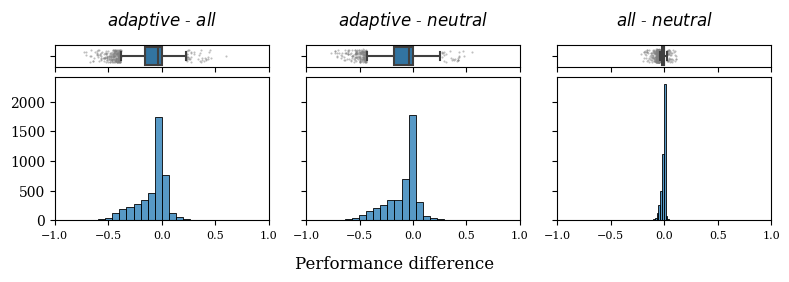

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_all.pdf


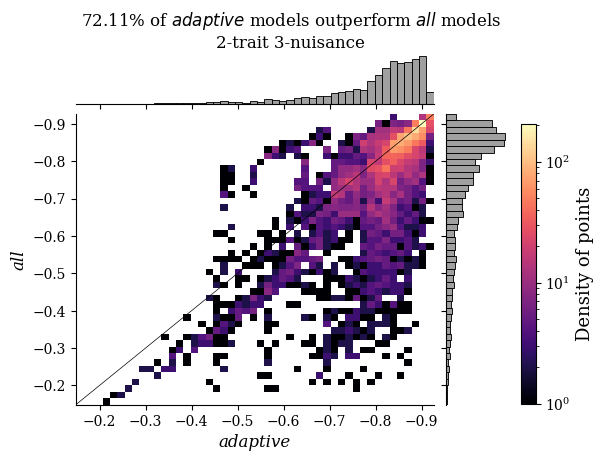

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_neutral.pdf


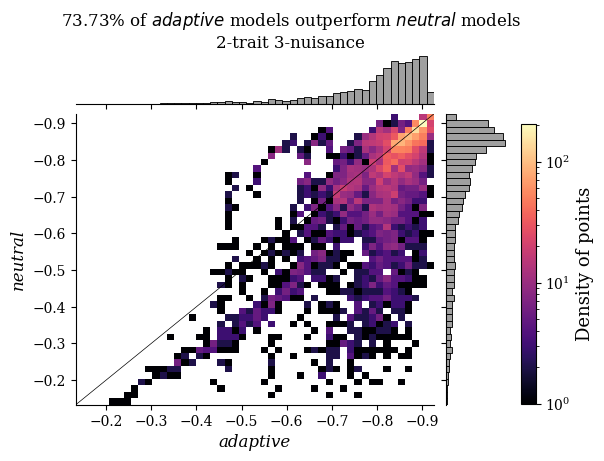

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_all_neutral.pdf


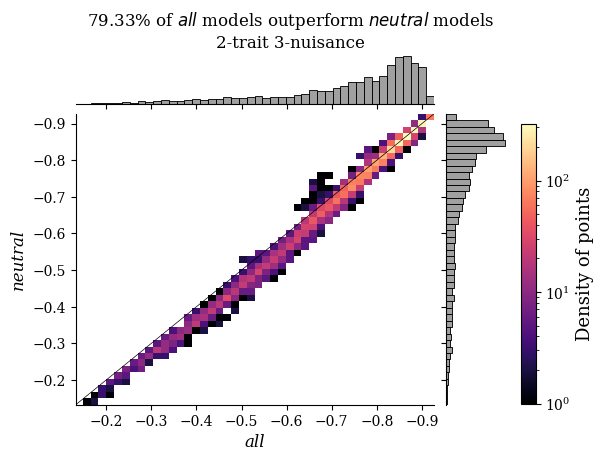

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_histobox_diffs.pdf


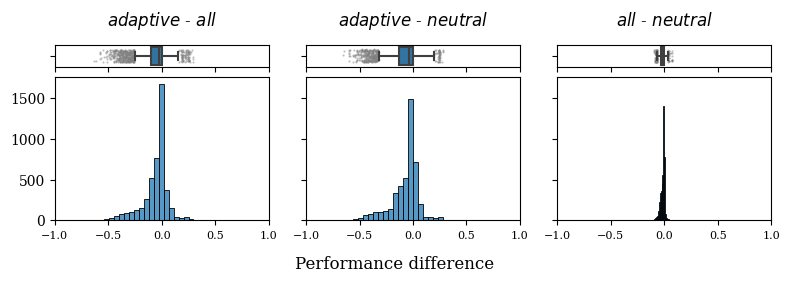

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_all.pdf


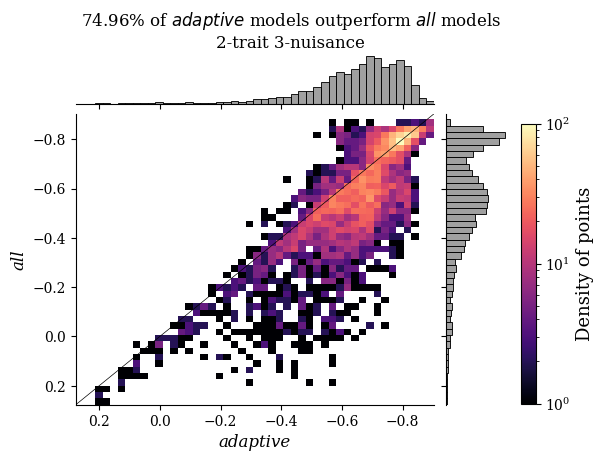

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_neutral.pdf


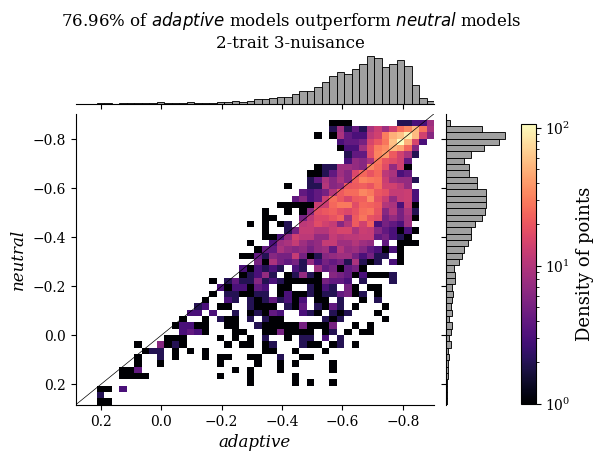

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_all_neutral.pdf


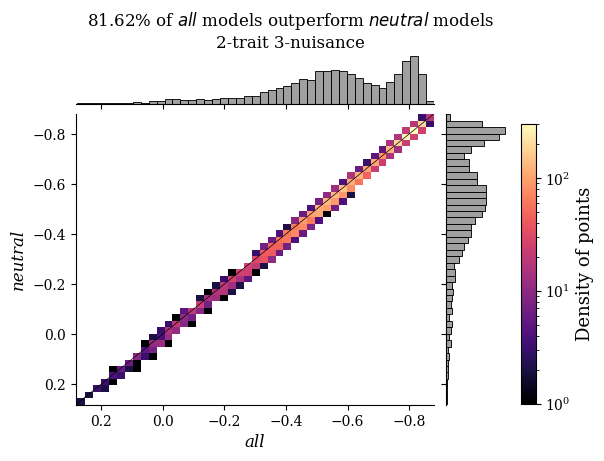

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_histobox_diffs.pdf


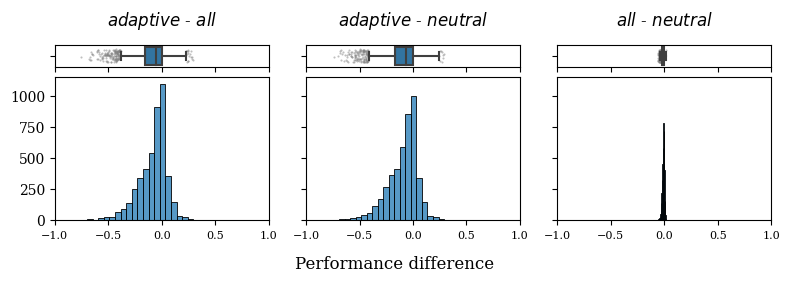

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_all.pdf


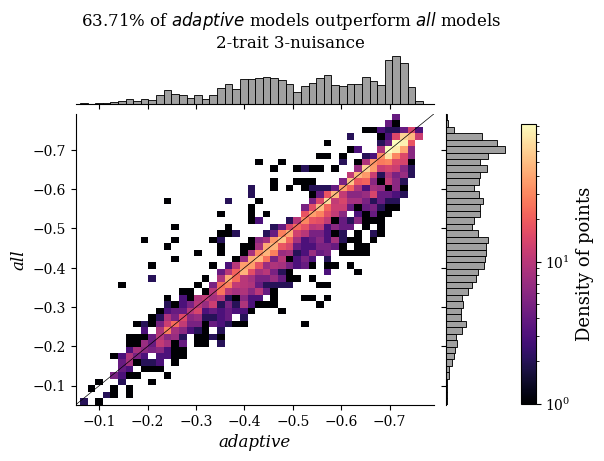

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_neutral.pdf


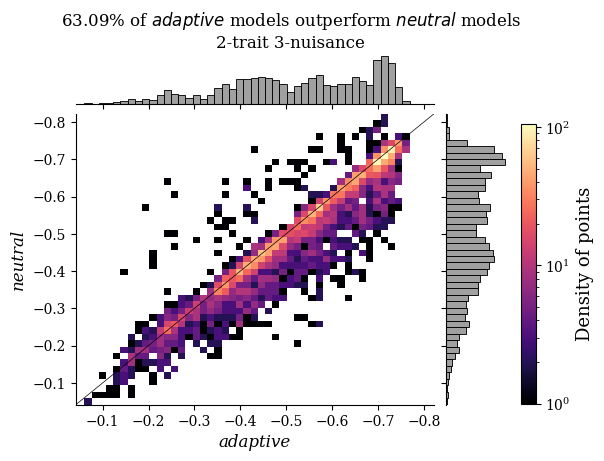

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_all_neutral.pdf


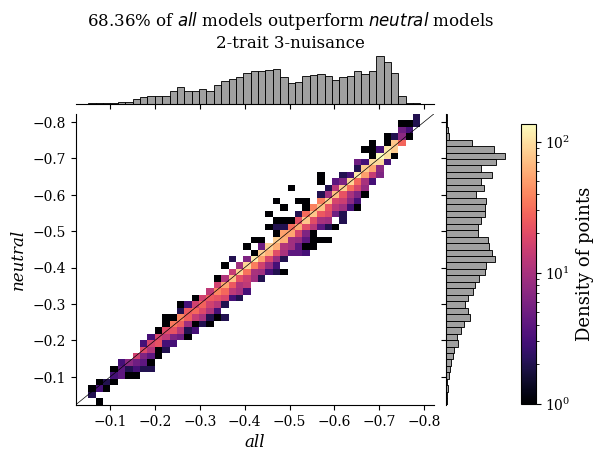

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_histobox_diffs.pdf


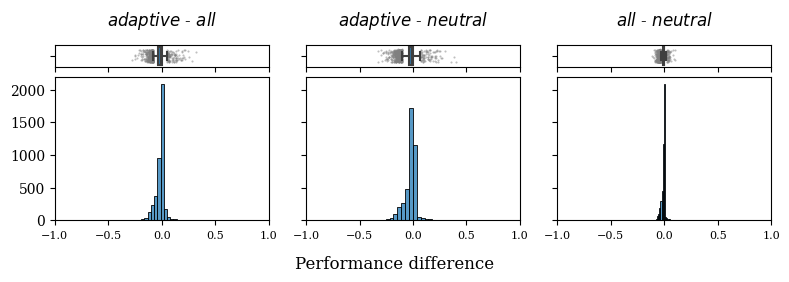

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_all.pdf


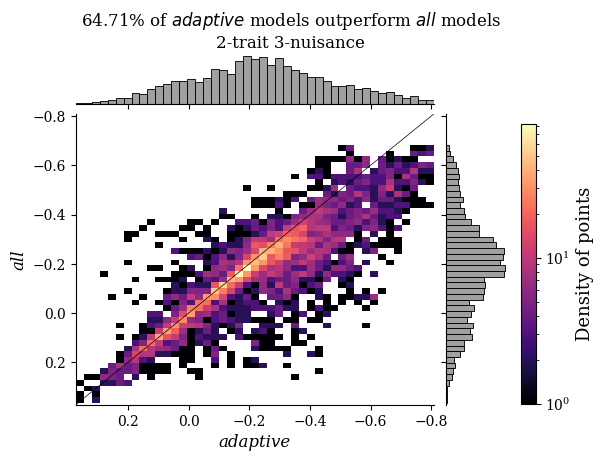

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_neutral.pdf


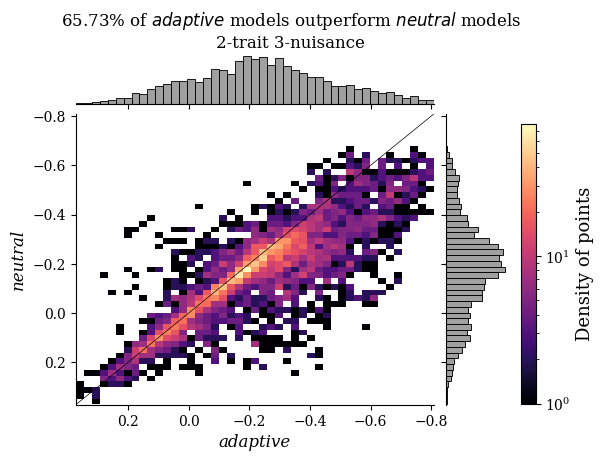

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_all_neutral.pdf


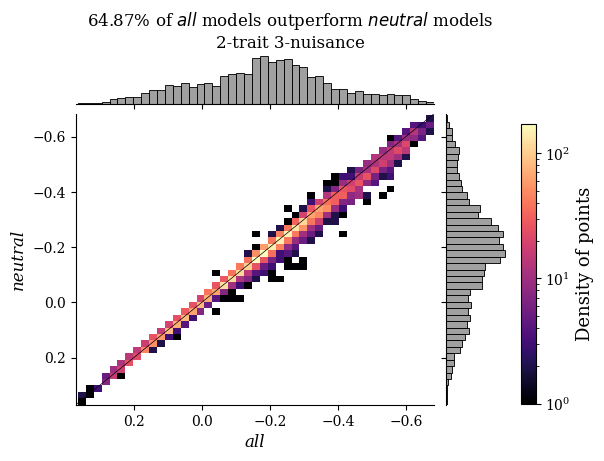

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_histobox_diffs.pdf


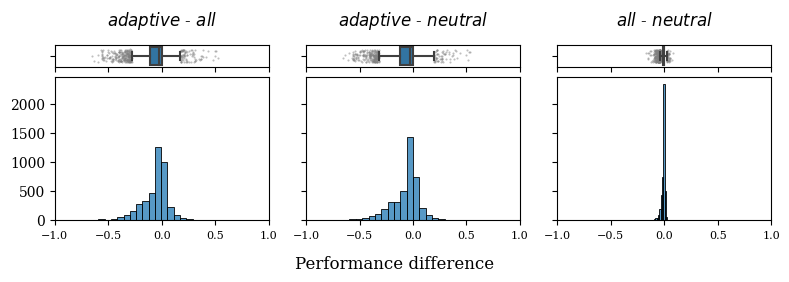

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_all.pdf


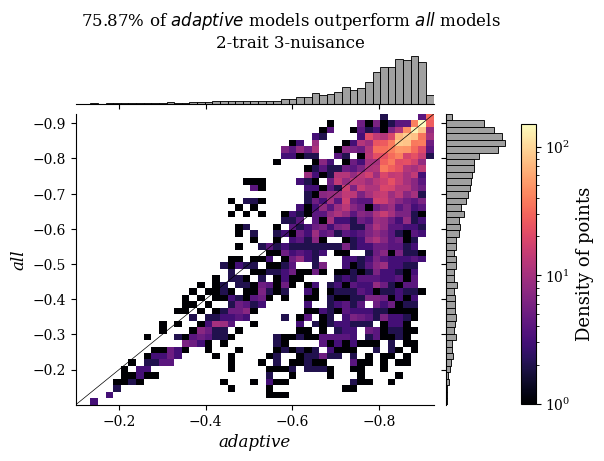

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_neutral.pdf


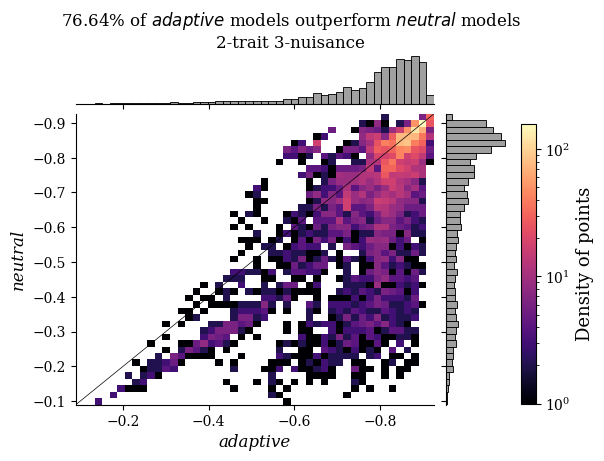

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_all_neutral.pdf


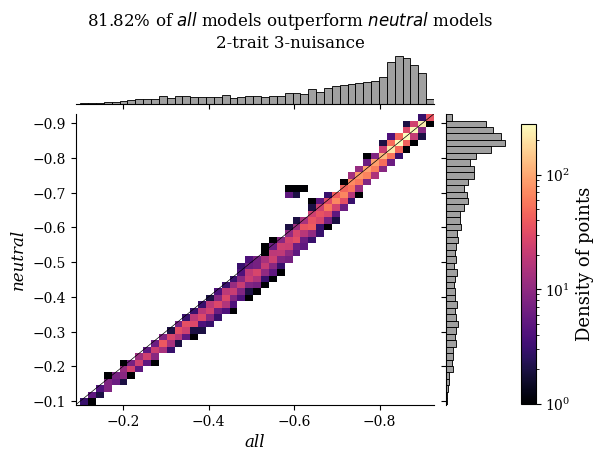

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_histobox_diffs.pdf


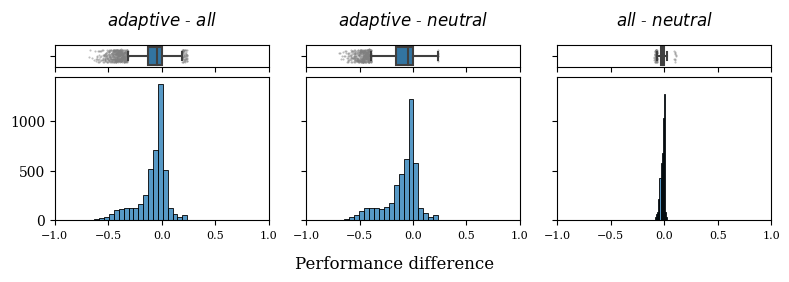

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_all.pdf


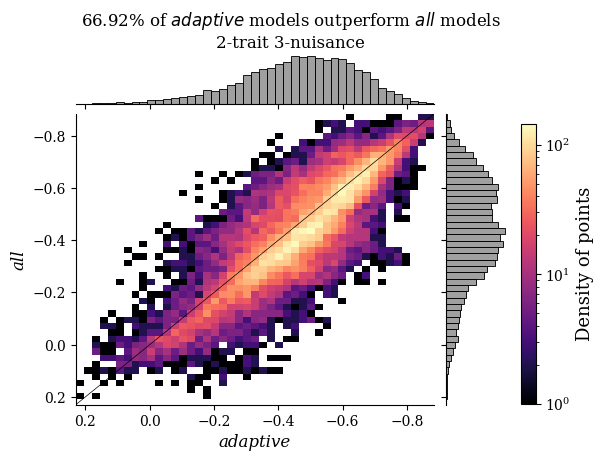

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_neutral.pdf


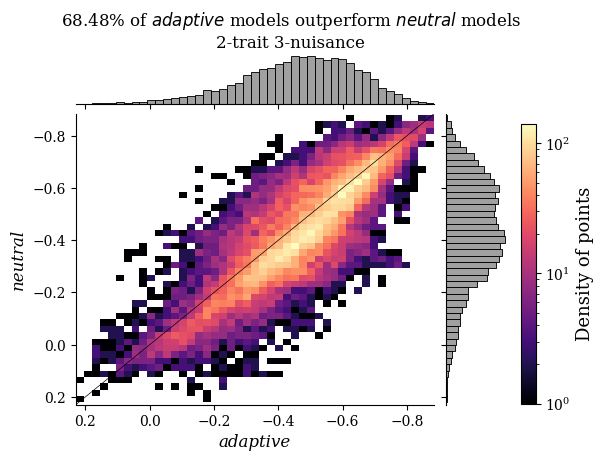

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_all_neutral.pdf


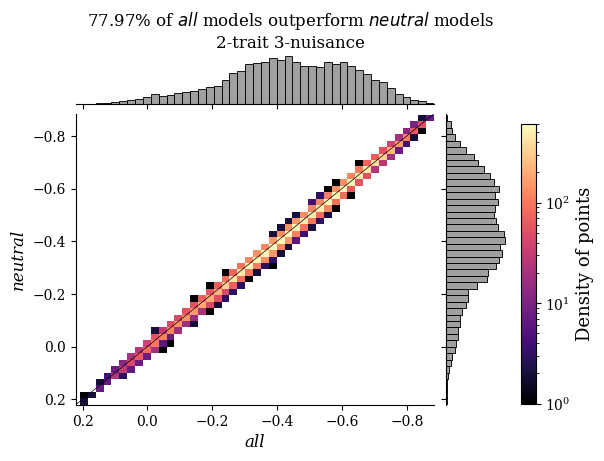

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_histobox_diffs.pdf


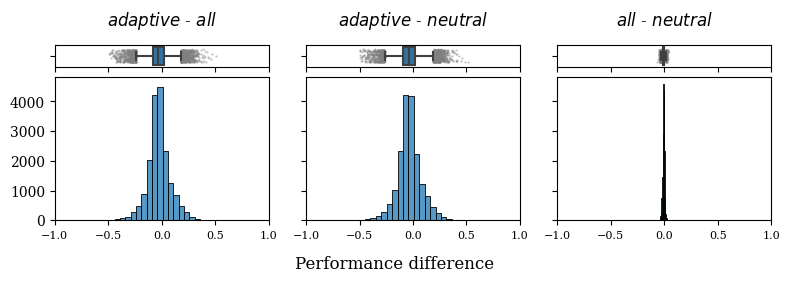

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_all.pdf


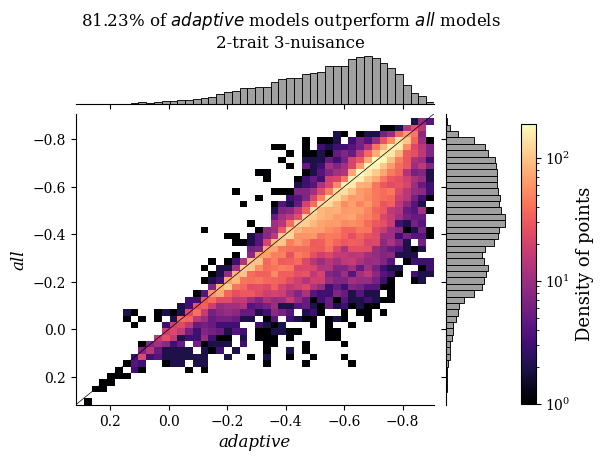

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_neutral.pdf


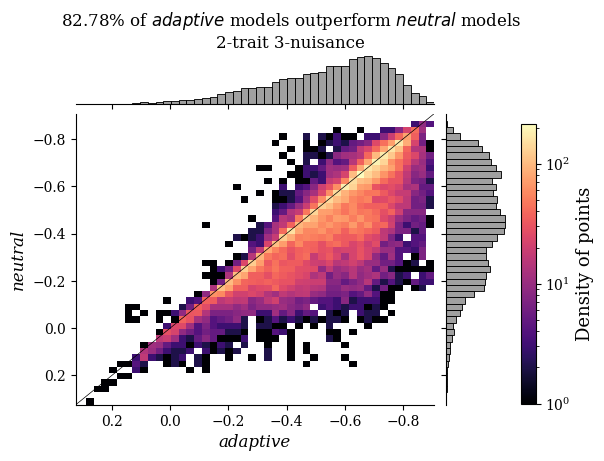

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_all_neutral.pdf


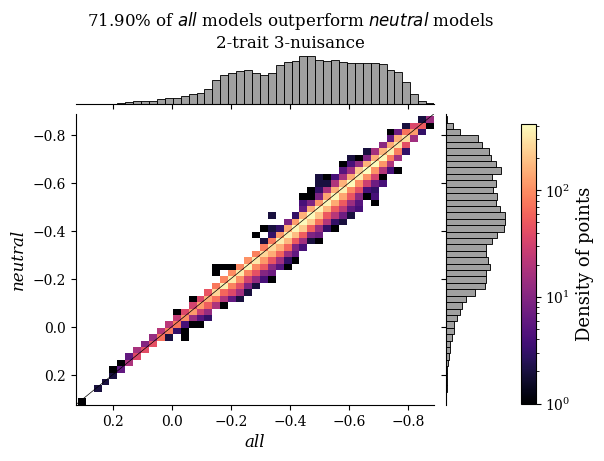

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_histobox_diffs.pdf


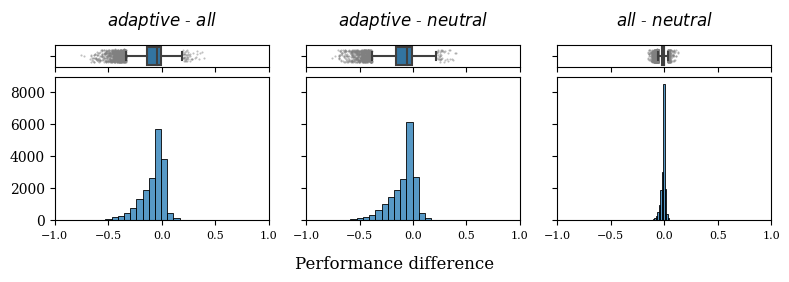

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_all.pdf


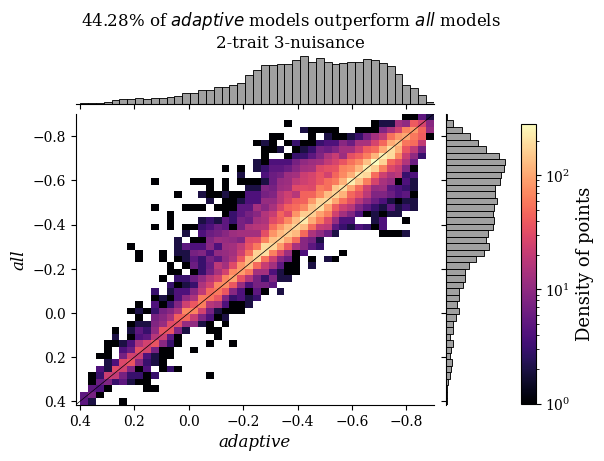

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_neutral.pdf


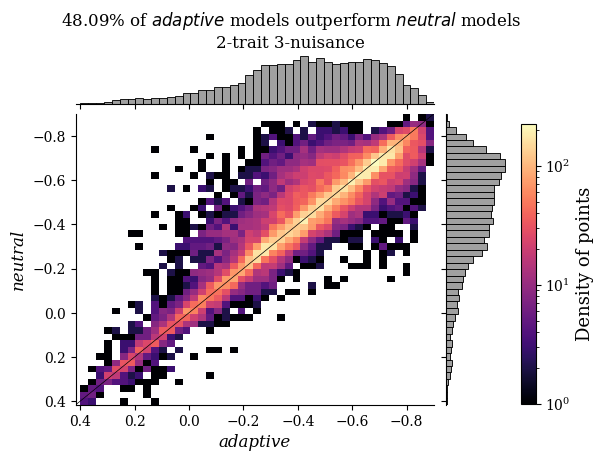

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_all_neutral.pdf


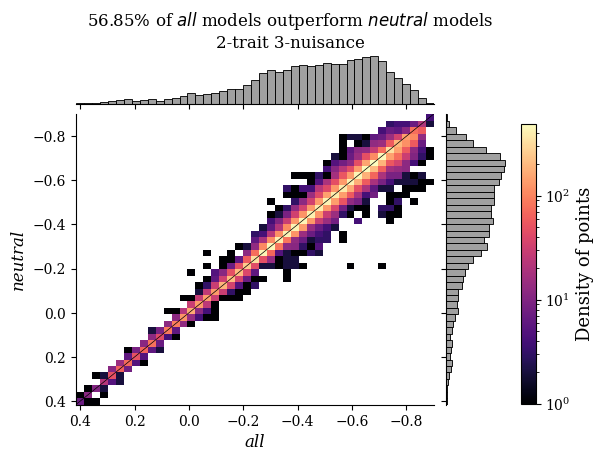

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_histobox_diffs.pdf


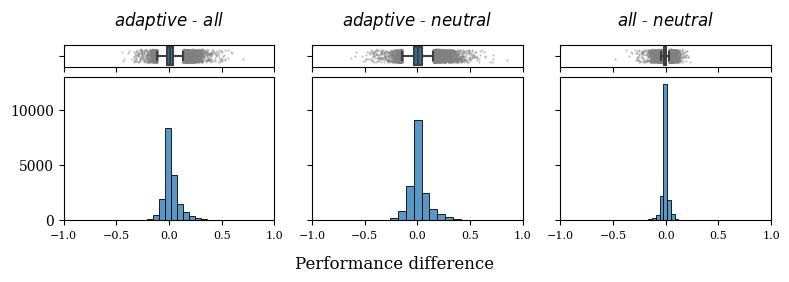

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_all.pdf


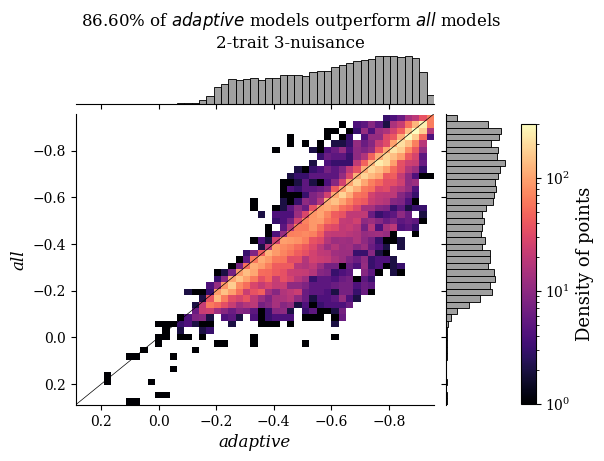

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_neutral.pdf


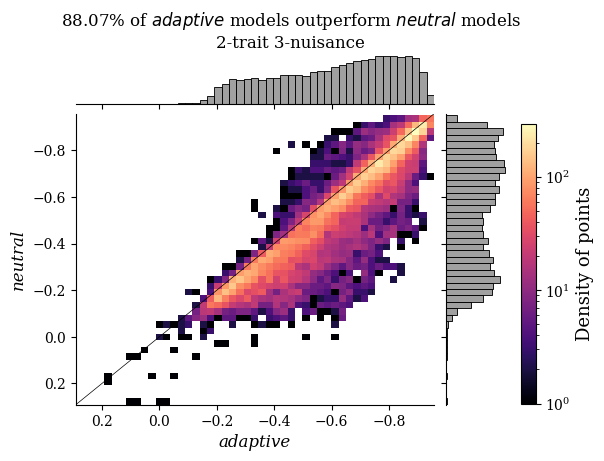

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_all_neutral.pdf


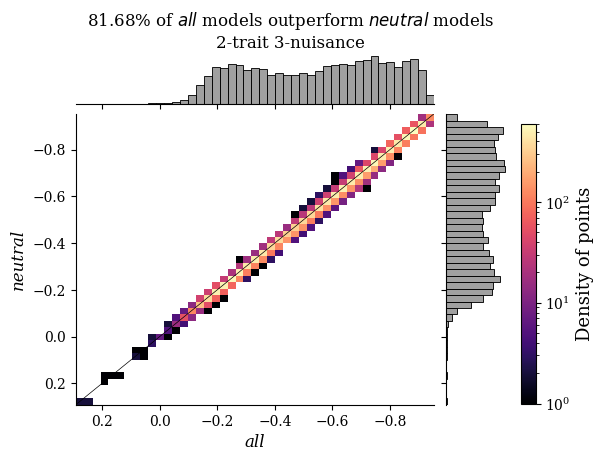

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_histobox_diffs.pdf


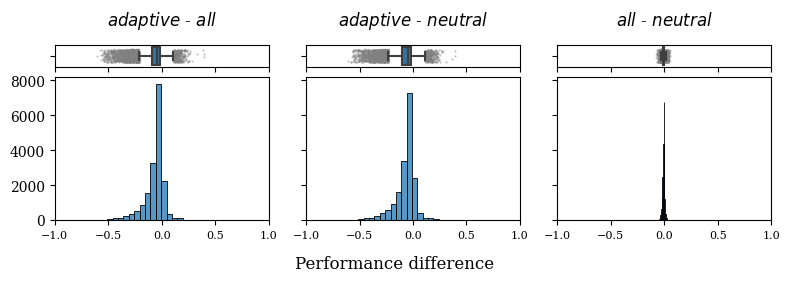

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_all.pdf


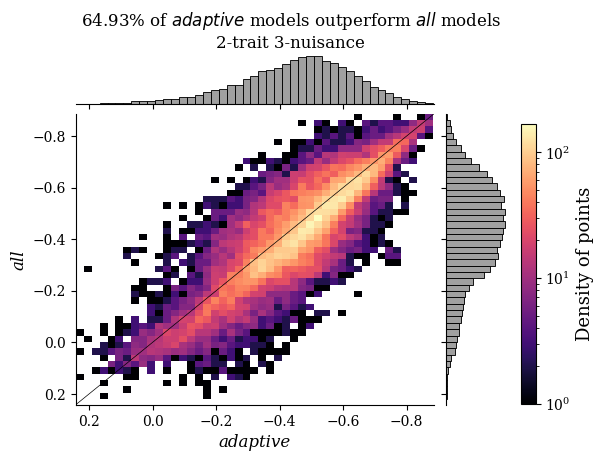

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_adaptive_neutral.pdf


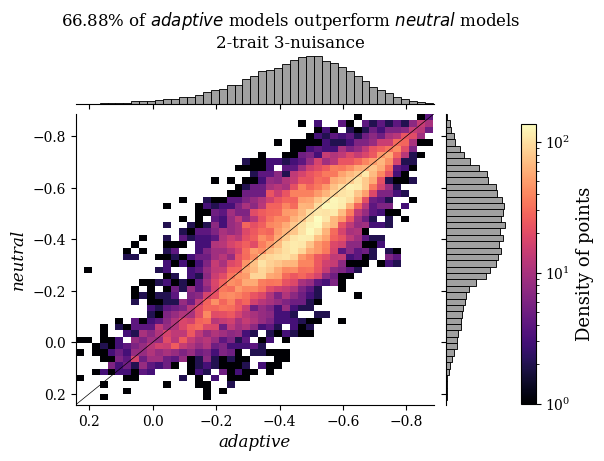

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_scatter2d_all_neutral.pdf


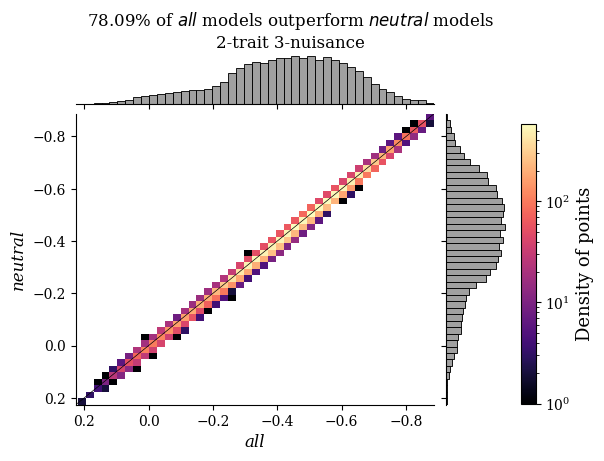

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_lfmm2_histobox_diffs.pdf


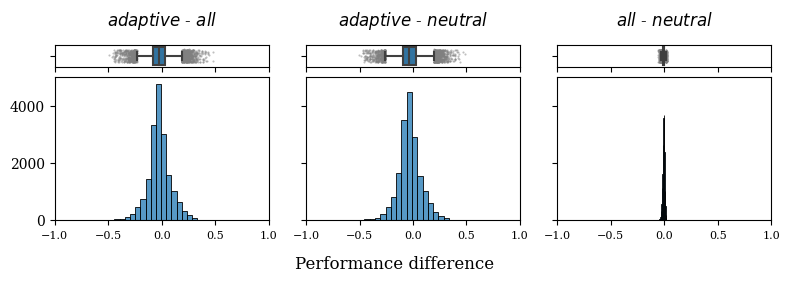

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_all.pdf


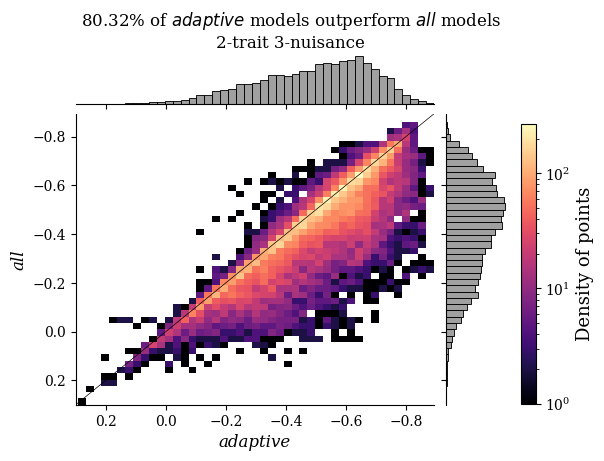

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_adaptive_neutral.pdf


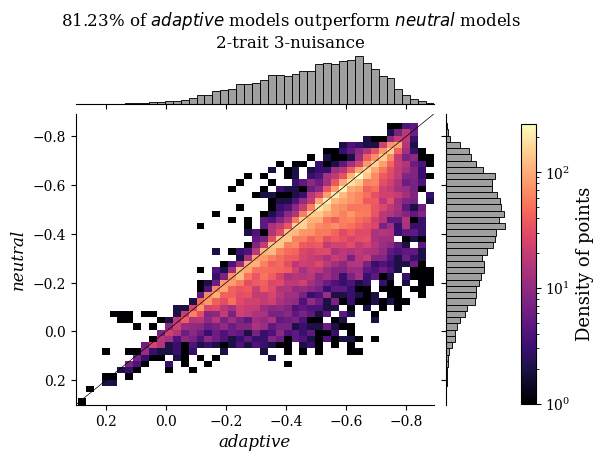

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_scatter2d_all_neutral.pdf


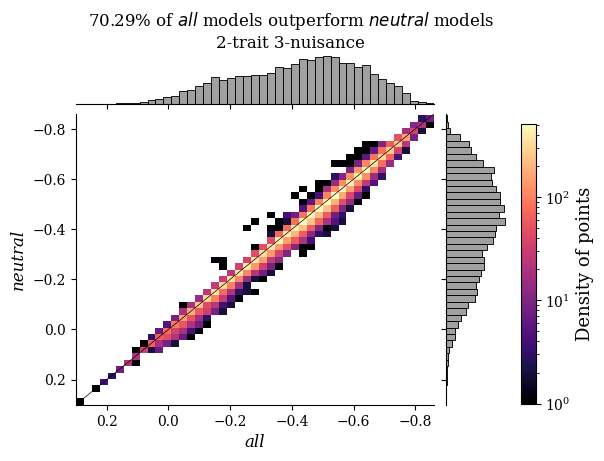

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-nocorr_histobox_diffs.pdf


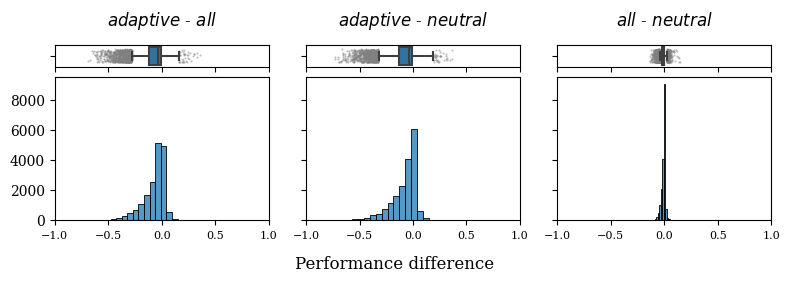

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_all.pdf


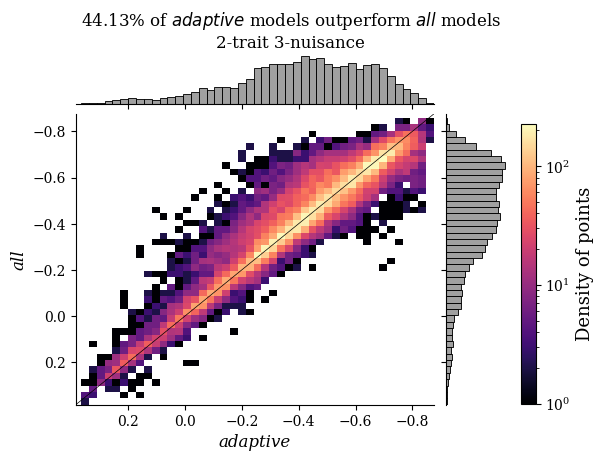

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_adaptive_neutral.pdf


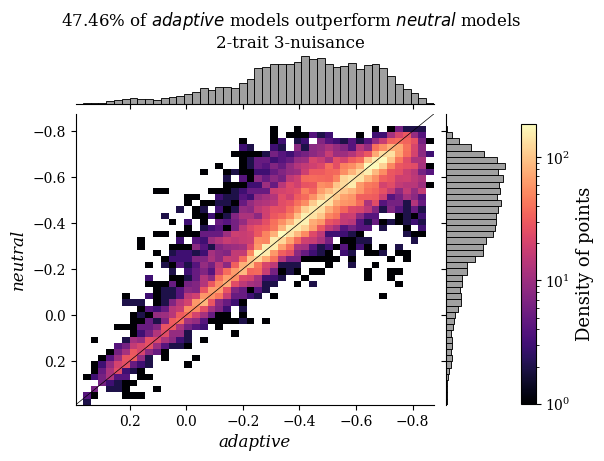

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_scatter2d_all_neutral.pdf


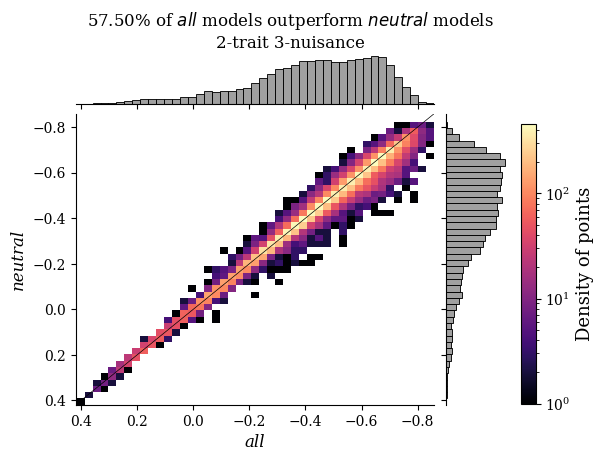

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_rda-structcorr_histobox_diffs.pdf


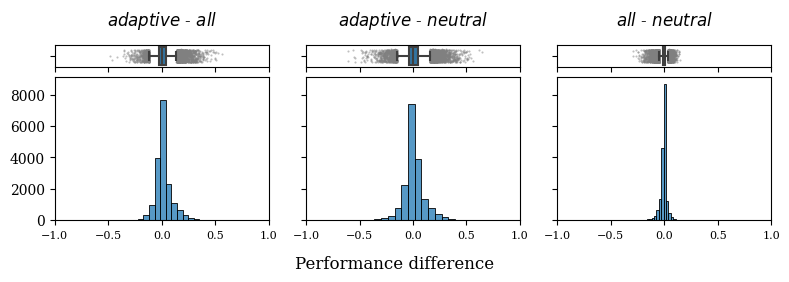

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_all.pdf


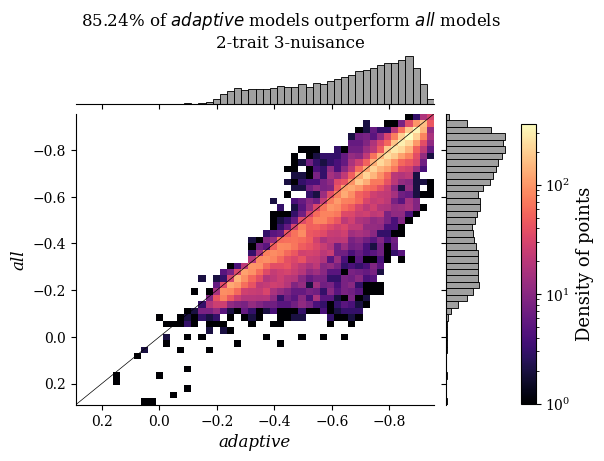

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_adaptive_neutral.pdf


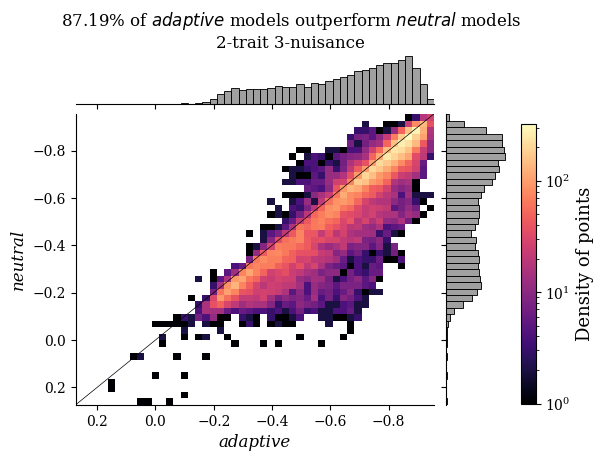

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_scatter2d_all_neutral.pdf


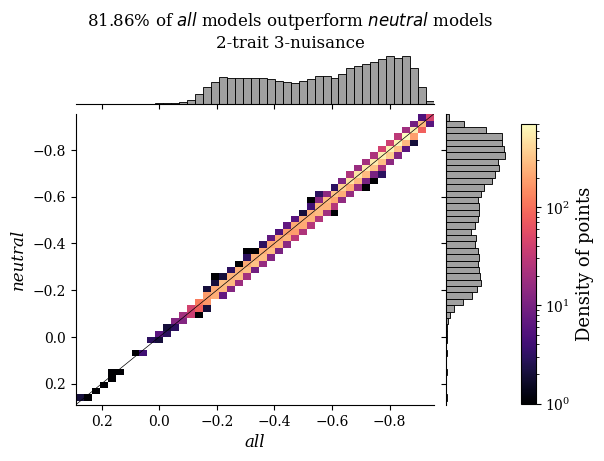

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/2-trait_3-nuisance_GF_histobox_diffs.pdf


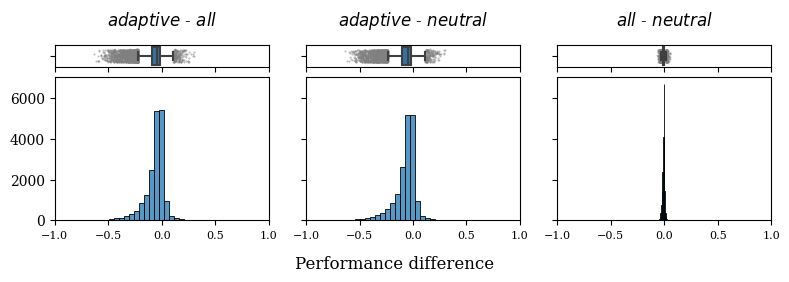

In [29]:
diffs_by_program = calc_nuis_diffs(hue='program')

In [30]:
diffs['1-trait 1-nuisance'][None]['adaptive-all']

highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_1_1231094    0.027071
highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_2_1231094    0.009293
highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_3_1231094   -0.002020
highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_4_1231094   -0.010909
highly-polygenic_1-trait_no-pleiotropy_nan_Est-Clines_N-cline-center-to-edge_m-constant_lfmm2_5_1231094   -0.014949
                                                                                                             ...   
oligogenic_1-trait_no-pleiotropy_nan_SS-Mtn_N-variable_m-variable_rda-structcorr_96_1231258                0.348431
oligogenic_1-trait_no-pleiotropy_nan_SS-Mtn_N-variable_m-variable_rda-structcorr_97_1231258                0.274633
oligogenic_1-trait_no-pleiotropy_nan_SS-Mtn_N-variable_m-variable_rda-st

### save

In [31]:
for name, _diffs in zip(['diffs', 'diffs_by_program'], [diffs, diffs_by_program]):
    pkl = f'{figdir}/{name}.pkl'
    
    pkldump(_diffs, pkl)
    print(pkl)

/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/diffs.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/06_Q3_effect_of_nuisance_envs/figs/diffs_by_program.pkl


In [32]:
formatclock(dt.now() - t0)

'0-00:03:56'

###### 